# **HR: EMPLOYEE RETENTION**

# **Business Understanding**

Employee retention refers to an organization’s ability to maintain a stable and engaged workforce by creating an environment where employees are motivated to stay and grow. Strong retention safeguards institutional knowledge, sustains productivity, and enhances the organization’s reputation as an employer of choice. It is driven by factors such as fair compensation, career development opportunities, supportive leadership, manageable workloads, and a sense of purpose.

**Why Retention Matters More Than Hiring?**

Hiring new employees is significantly more costly than retaining current ones. Recruitment expenses, training, and the productivity loss during the onboarding phase often exceed 30–150% of the departing employee’s annual salary. Beyond these visible costs, organizations also lose valuable institutional knowledge, disrupt team dynamics, and risk lowered customer satisfaction—consequences that can take months or even years to fully recover from.

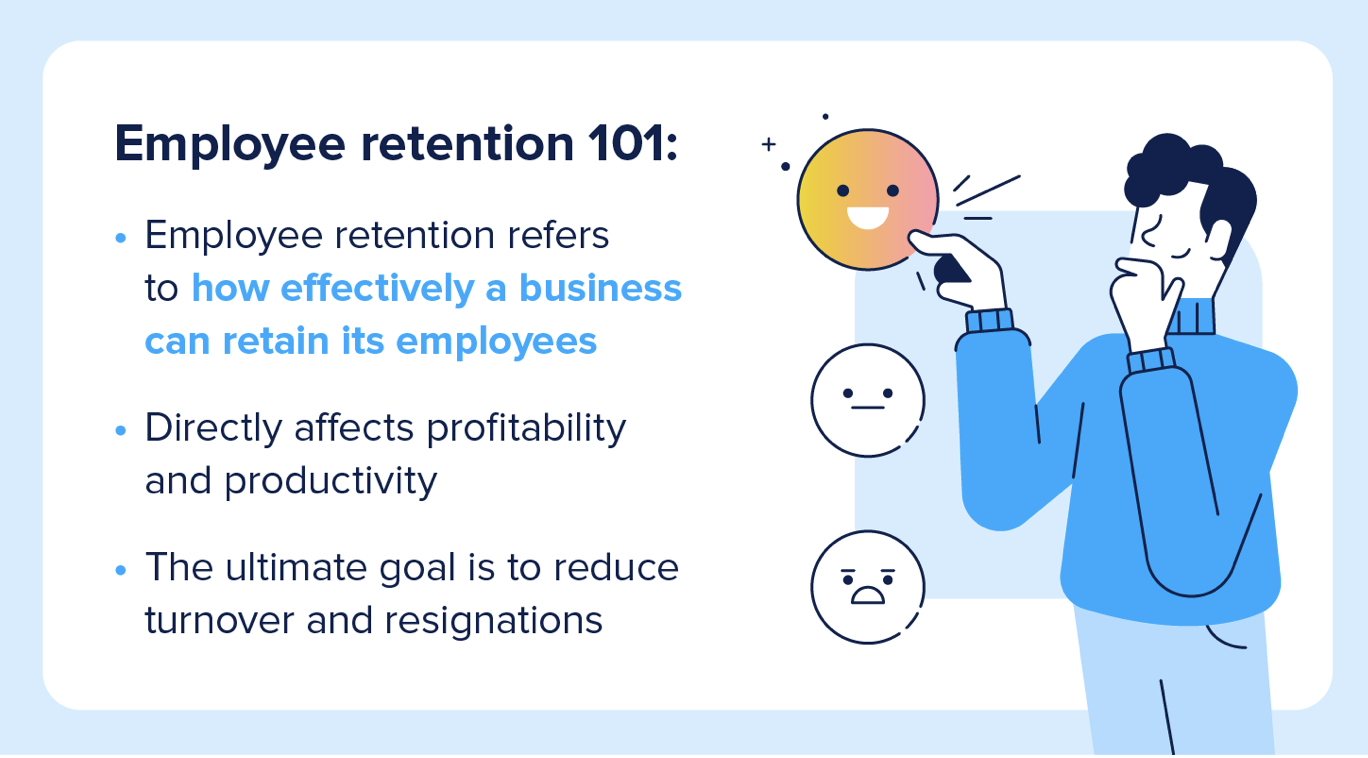

source: timeclick.com/cost-of-hiring-an-employee/ & https://www.zoomshift.com/blog/employee-retention-strategies/

# **Problem Statement**


HR needs clarity on **which employees are most valuable and most at risk of leaving.** The HR wants to know how to **retain top performers** and **what things that can be improvise**. Without data-driven segmentatation, HR risks spending inefficiently and potentially losing top performers. So, here are two questions that HR needs to answers:

1. **who are our top performers at high risk of resigning?**
2. **who are our low performers at high risk of resigning?** → to know what we're going to do with it, let it resign or upgrading them.

# **Goals**

* **Business Goals**: Reduce unnecessasry hiring by retaining the right people, improve performance continuity.
* **Analytics Goal**: create meaningful employee clusters and a **resignation risk score** to rank people inside each cluster.


If we know how to treat the employee, besides less hiring cost expenses it will also;
* increased productivity and loyalty
* stronger customer relationships
* less stress = fewer sick days
* higher employee retention
* good reputation, which atract best possible potential employees.

source: https://therecruitmentco.uk/5-benefits-kind-employees/

And to maintain it, we will give recommendation and treatments based on current cluster. Based on https://acumenconnections.com/10-best-employee-benefits-to-hire-and-retain-top-talent/ there are several employee benefits to look for;

1. Retirement plans
2. Flexible schedules
3. Health, vision, dental
4. Health & wellness
5. Team bonding activities.
6. Mental health help & support
7. More paid time off (PTO)
8. Food events
9. Continuing education & student loan assitance
10. Pet-friendly workplace


# **Analytical Approach**

We combine two laters for maximum clairty and actionability:

**Layer A - Clustering (unsupervised)**
* Group similar employees (e.g., High-performance & underpaid, stable & fairly paid, new hires in ramp).
* Outcome: HR gets easy-to-understand **segments** with clear drivers (tenure, promotions, etc).


**Layer B - Risk index**



# **Metrics & Evaluation**

* Cluster Quality (silhoutte score, elbow method)
* Risk Index Quality

## **Workflow**

1. **Data Preparations + EDA**
2. **Feature Engineering**
3. **Preprocessing Pipeline**
4. **Clustering**
5. **Risk index**
6. **Performance x Risk Quadrant**
7. **Notebook Deliverable**
8. **Streamlit App**
9. **Requirements & Deploy**

# **PHASE 1 - DATA PREPARATIONS**


First thing first, import the libraries that we need later.

In [1]:
!pip install -q streamlit plotly altair


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 103.8 MB/s eta 0:00:00


In [2]:
!pip install -q pandas numpy scipy scikit-learn joblib


In [3]:
# standard library
import os
import sys
import re
import math
import json
import pickle
import random
import warnings
import itertools
from pathlib import Path

# core for data
import numpy as np
import pandas as pd

#w visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# statistics
from scipy import stats
from scipy.stats import chi2_contingency

# scikit-learn: preprocessing, clustering, modeling, evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# clustering & projections
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# metrics (unsupervised)
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score
)

from sklearn.inspection import permutation_importance


# persistence
import joblib


# streamlit app (UI)
import streamlit as st



In [4]:
!pip -q install gdown
import gdown, csv

In [5]:
file_id = "1upMxpRwwjapu8zDhQgCclE0vMduKrazQ"
out_path = "emploforML.csv"

gdown.download(id=file_id, output=out_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1upMxpRwwjapu8zDhQgCclE0vMduKrazQ
To: /content/emploforML.csv
100%|██████████| 221k/221k [00:00<00:00, 65.6MB/s]


'emploforML.csv'

In [6]:
df = pd.read_csv(out_path)
df.head(10)

,Unnamed: 0,employee_id,age,gender,marital_status,city,education_level,years_experience,weekly_hours,department,bonus_percentage,performance_score,overtime_hours,monthly_income,income_class
0,0,1,39.0,Other,Single,Surabaya,S1,10.0,42.3,Marketing,6.5,64.3,5.8,7887,Low
1,1,2,34.0,Female,Single,Surabaya,S1,10.0,41.0,IT,9.7,87.6,NaN,10870,High
2,2,3,40.0,Male,Married,Surabaya,SMA,4.0,42.3,HR,12.7,61.5,12.3,6228,Low
3,3,4,47.0,Female,Single,Jakarta,S1,4.0,42.2,Marketing,NaN,81.6,13.3,7041,Low
4,4,5,33.0,Male,Married,Surabaya,D3,15.0,31.1,IT,11.5,71.9,13.7,9657,High
5,5,6,33.0,Female,Married,Jakarta,D3,12.0,43.2,HR,7.4,73.3,1.9,11030,High
6,6,7,48.0,Male,Divorced,Jakarta,S1,15.0,36.6,HR,NaN,93.6,6.6,11961,High
7,7,8,41.0,Female,Single,Surabaya,S1,12.0,34.5,Sales,NaN,62.5,3.2,10393,High
8,8,9,31.0,Female,Single,Jakarta,D3,11.0,34.5,HR,NaN,80.9,10.9,10853,High
9,9,10,39.0,Male,Married,Bandung,S2,1.0,42.2,IT,NaN,80.5,3.4,4159,Low


Then, we want to check how many duplicates

In [7]:
df.duplicated().sum()

np.int64(0)

The result above shows that, in this data frame there are no duplicates. Next, we want to know if there's any missing values and where the missing values located at.

In [8]:
df.isnull().any().any()

np.True_

It says, there're missing values. Now we want to know where is it. Following with count the percentages of it.

In [9]:
df[df.isna().any(axis=1)]

,Unnamed: 0,employee_id,age,gender,marital_status,city,education_level,years_experience,weekly_hours,department,bonus_percentage,performance_score,overtime_hours,monthly_income,income_class
1,1,2,34.0,Female,Single,Surabaya,S1,10.0,41.0,IT,9.7,87.6,NaN,10870,High
3,3,4,47.0,Female,Single,Jakarta,S1,4.0,42.2,Marketing,NaN,81.6,13.3,7041,Low
6,6,7,48.0,Male,Divorced,Jakarta,S1,15.0,36.6,HR,NaN,93.6,6.6,11961,High
7,7,8,41.0,Female,Single,Surabaya,S1,12.0,34.5,Sales,NaN,62.5,3.2,10393,High
8,8,9,31.0,Female,Single,Jakarta,D3,11.0,34.5,HR,NaN,80.9,10.9,10853,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3023,3023,2084,17.0,Female,Single,Jakarta,SMA,15.0,37.4,Finance,NaN,65.5,7.3,12340,High
3025,3025,2896,66.0,Female,Married,Surabaya,S1,19.0,42.0,Sales,NaN,68.9,3.7,12508,High
3026,3026,2604,115.0,Female,Married,Surabaya,S1,11.0,46.9,Marketing,NaN,68.0,16.4,11653,High
3027,3027,1227,35.0,Male,Married,Jakarta,SMA,7.0,36.4,NaN,4.8,74.1,13.5,4435,Low


In [10]:
(df.isna().mean() * 100).round(2).sort_values(ascending=False)


,0
bonus_percentage,39.97
overtime_hours,7.95
age,6.17
weekly_hours,5.21
department,5.02
years_experience,4.49
Unnamed: 0,0.00
education_level,0.00
city,0.00
marital_status,0.00


From the table above, the highest columns of missing values is in `bonus_percentage` (39.97%), following with `overtime_hours` (7.95%), `age` (6.17%), `weekly_hours` (5.21%), `department` (5.02%), and `years_experience` (4.49%).

The` bonus_percentage `  `is **critical to handle** because it's a large portion, where the rest is moderate.

So, we do missing values handle from the highest.


### **1. `bonus_percentage`**

Impute `bonus_percentage` with the median based on their department (with safe fallbacks).

In [11]:
print("Before:", df["bonus_percentage"].isna().mean().round(3))

Before: 0.4


In [12]:
# Median bonus per department (computed only from rows where both are present)
dept_bonus_median = (
    df.loc[df["department"].notna() & df["bonus_percentage"].notna()]
      .groupby("department")["bonus_percentage"]
      .median()
)

In [13]:
# Map department-level medians into a helper column
df["__dept_bonus_med"] = df["department"].map(dept_bonus_median)

In [14]:
# Fill bonus by department median first
df["bonus_percentage"] = df["bonus_percentage"].fillna(df["__dept_bonus_med"])

In [15]:
#  Fallback: if department is missing or unseen, use global median
global_bonus_median = df["bonus_percentage"].median(skipna=True)
df["bonus_percentage"] = df["bonus_percentage"].fillna(global_bonus_median)

In [16]:
# Cleanup helper column
df.drop(columns=["__dept_bonus_med"], inplace=True)

In [17]:
# Quick check
print("After :", df["bonus_percentage"].isna().mean().round(3))

After : 0.0


After we done the most critical one, we are moving to the overtime_hours (7.95%)

###**2. `overtime_hours`**

We impute `overtime_hours` with median based on age, department

In [18]:
# check current missing percentage
print("Before:", df["overtime_hours"].isna().mean().round(3))

Before: 0.08


In [19]:
# create age bins so groups aren’t too granular
df["__age_bin"] = pd.cut(df["age"], bins=[0,25,35,45,55,65,100], right=False)

In [20]:
# 2 make median overtime grouped by (age_bin, department)
group_overtime_median = (
    df.loc[df["overtime_hours"].notna() & df["__age_bin"].notna() & df["department"].notna()]
      .groupby(["__age_bin", "department"])["overtime_hours"]
      .median()
)

/tmp/ipython-input-825738246.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["__age_bin", "department"])["overtime_hours"]


In [21]:
# 3 then, mapping medians into helper column
df["__overtime_med"] = df.set_index(["__age_bin","department"]).index.map(group_overtime_median)

In [22]:
# first fill overtime with group medians
df["overtime_hours"] = df["overtime_hours"].fillna(df["__overtime_med"])

In [23]:
# fallback: fill remaining NaN with global median
global_overtime_median = df["overtime_hours"].median(skipna=True)
df["overtime_hours"] = df["overtime_hours"].fillna(global_overtime_median)

In [24]:
# drop helper coloumns that we use
df.drop(columns=["__age_bin","__overtime_med"], inplace=True)

In [25]:
# final check
print("After :", df["overtime_hours"].isna().mean().round(3))

After : 0.0


### **`3. age`**

We handle through
* `years_experience`→ grouped into ranges (0–5, 5–10, … 40–50)
* `monthly_income`→  split into quintiles (low → high earners)
*  age through binning (we assume the earliest people working at 20 and end at 80).

In [26]:

print("Before:", df["age"].isna().mean().round(3))

Before: 0.062


In [27]:
# create bins for experience and income
df["__exp_bin"] = pd.cut(df["years_experience"], bins=[0,5,10,20,30,40,50], right=False)
df["__income_bin"] = pd.qcut(df["monthly_income"], q=5, duplicates="drop")


In [28]:
# create age bins starting from 20 to 80
df["__age_bin"] = pd.cut(df["age"], bins=[20,30,40,50,60,70,80], right=False)

In [29]:
# median age by (dept, edu, exp_bin, income_bin)
group_age_median = (
    df.loc[df["age"].notna() & df["department"].notna() & df["education_level"].notna()]
      .groupby(["department","education_level","__exp_bin","__income_bin"])["age"]
      .median()
)


/tmp/ipython-input-421981568.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["department","education_level","__exp_bin","__income_bin"])["age"]


In [30]:
# map medians to helper columns
idx_keys = list(zip(df["department"], df["education_level"], df["__exp_bin"], df["__income_bin"]))
df["__age_med"] = [group_age_median.get(k, np.nan) for k in idx_keys]

In [31]:
# fill stepwise
df["age"] = df["age"].fillna(df["__age_med"])

In [32]:
# fallback 1: department + education median
dept_edu_age_median = (
    df.loc[df["age"].notna()]
      .groupby(["department","education_level"])["age"].median()
)
df["__dept_edu_age_med"] = [dept_edu_age_median.get((d,e), np.nan) for d,e in zip(df["department"],df["education_level"])]
df["age"] = df["age"].fillna(df["__dept_edu_age_med"])

In [33]:
# fallback 2: department median
dept_age_median = df.groupby("department")["age"].median()
df["__dept_age_med"] = df["department"].map(dept_age_median)
df["age"] = df["age"].fillna(df["__dept_age_med"])

In [34]:
# fallback 3: global median
df["age"] = df["age"].fillna(df["age"].median(skipna=True))

In [35]:
# cleanup helpers
df.drop(columns=["__exp_bin","__income_bin","__age_bin","__age_med","__dept_edu_age_med","__dept_age_med"],
        inplace=True, errors="ignore")

In [36]:
# final check
print("After :", df["age"].isna().mean().round(3))


After : 0.0


### **3. `weekly_hours`**

we impute same like we did, with median of age and department.

In [37]:
print("Before:", df["weekly_hours"].isna().mean().round(3))


Before: 0.052


In [38]:
# create age bins (so groups aren’t too granular)
df["__age_bin"] = pd.cut(df["age"], bins=[0,25,35,45,55,65,100], right=False)

In [39]:
# create median weekly hours by (age_bin, department)
group_weekly_median = (
    df.loc[df["weekly_hours"].notna() & df["__age_bin"].notna() & df["department"].notna()]
      .groupby(["__age_bin","department"])["weekly_hours"]
      .median()
)

/tmp/ipython-input-2284675403.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["__age_bin","department"])["weekly_hours"]


In [40]:
# make a map group medians into helper column
df["__weekly_med"] = df.set_index(["__age_bin","department"]).index.map(group_weekly_median)

In [41]:
# fill with group medians
df["weekly_hours"] = df["weekly_hours"].fillna(df["__weekly_med"])

In [42]:
# fallback: fill remaining NaN with global median
global_weekly_median = df["weekly_hours"].median(skipna=True)
df["weekly_hours"] = df["weekly_hours"].fillna(global_weekly_median)


In [43]:
# clean the helper columns
df.drop(columns=["__age_bin","__weekly_med"], inplace=True)

In [44]:
# final quick check
print("After :", df["weekly_hours"].isna().mean().round(3))


After : 0.0


### **4. `departments`**

In this columns we will impute with "Unknown" since it seems to risky to make assumptions

In [45]:
# fill with "Unknown"
df["department"] = df["department"].fillna("Unknown")

In [46]:
# 2) quick check
print("After :", df["department"].isna().mean().round(3))

After : 0.0


### **`5. years_experienc`e**

We do imputation based on median by age.

In [47]:
print("Before:", df["years_experience"].isna().mean().round(3))

Before: 0.045


In [48]:
# create age bins (to avoid one-to-one age mapping)
df["__age_bin"] = pd.cut(df["age"], bins=[0,20,30,40,50,60,70, 80], right=False)

In [49]:
# median years_experience by age_bin
age_exp_median = (
    df.loc[df["years_experience"].notna() & df["__age_bin"].notna()]
      .groupby("__age_bin")["years_experience"]
      .median()
)

/tmp/ipython-input-667288788.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("__age_bin")["years_experience"]


In [50]:
# 3) Map to helper column
df["__exp_med"] = df["__age_bin"].map(age_exp_median)

In [51]:
# 4) Fill with bin-level median first
df["years_experience"] = df["years_experience"].fillna(df["__exp_med"])


In [52]:

# 5) Fallback: global median if still missing
global_exp_median = df["years_experience"].median(skipna=True)
df["years_experience"] = df["years_experience"].fillna(global_exp_median)


In [53]:
# 6) Cleanup helpers
df.drop(columns=["__age_bin","__exp_med"], inplace=True)

In [54]:
# 7) Quick check
print("After :", df["years_experience"].isna().mean().round(3))

After : 0.0


Lastly, we want to make sure if there's any missing values left or not.

In [55]:
df.isnull().any().any()

np.False_

The results above shown, there's no missing values left. Now we are going to copy. So we have backup for the clean dataframe, just in case we need it.


In [56]:
df1 = df.copy()
df1.head(5)

,Unnamed: 0,employee_id,age,gender,marital_status,city,education_level,years_experience,weekly_hours,department,bonus_percentage,performance_score,overtime_hours,monthly_income,income_class
0,0,1,39.0,Other,Single,Surabaya,S1,10.0,42.3,Marketing,6.5,64.3,5.80,7887,Low
1,1,2,34.0,Female,Single,Surabaya,S1,10.0,41.0,IT,9.7,87.6,10.15,10870,High
2,2,3,40.0,Male,Married,Surabaya,SMA,4.0,42.3,HR,12.7,61.5,12.30,6228,Low
3,3,4,47.0,Female,Single,Jakarta,S1,4.0,42.2,Marketing,9.9,81.6,13.30,7041,Low
4,4,5,33.0,Male,Married,Surabaya,D3,15.0,31.1,IT,11.5,71.9,13.70,9657,High


In [57]:
df1.columns

Index(['Unnamed: 0', 'employee_id', 'age', 'gender', 'marital_status', 'city',
       'education_level', 'years_experience', 'weekly_hours', 'department',
       'bonus_percentage', 'performance_score', 'overtime_hours',
       'monthly_income', 'income_class'],
      dtype='object')

Then, we drop the column "Unnamed"

In [58]:
df1 = df1.drop("Unnamed: 0", axis=1)


In [59]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3030 entries, 0 to 3029
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   employee_id        3030 non-null   int64  
 1   age                3030 non-null   float64
 2   gender             3030 non-null   object 
 3   marital_status     3030 non-null   object 
 4   city               3030 non-null   object 
 5   education_level    3030 non-null   object 
 6   years_experience   3030 non-null   float64
 7   weekly_hours       3030 non-null   float64
 8   department         3030 non-null   object 
 9   bonus_percentage   3030 non-null   float64
 10  performance_score  3030 non-null   float64
 11  overtime_hours     3030 non-null   float64
 12  monthly_income     3030 non-null   int64  
 13  income_class       3030 non-null   object 
dtypes: float64(6), int64(2), object(6)
memory usage: 331.5+ KB


then, we are moving on to

## **EDA**

In [60]:
from pathlib import Path

In [61]:
print("Rows:", df1.shape[0], " | Columns:", df1.shape[1])
display(df1.head())

Rows: 3030  | Columns: 14


,employee_id,age,gender,marital_status,city,education_level,years_experience,weekly_hours,department,bonus_percentage,performance_score,overtime_hours,monthly_income,income_class
0,1,39.0,Other,Single,Surabaya,S1,10.0,42.3,Marketing,6.5,64.3,5.80,7887,Low
1,2,34.0,Female,Single,Surabaya,S1,10.0,41.0,IT,9.7,87.6,10.15,10870,High
2,3,40.0,Male,Married,Surabaya,SMA,4.0,42.3,HR,12.7,61.5,12.30,6228,Low
3,4,47.0,Female,Single,Jakarta,S1,4.0,42.2,Marketing,9.9,81.6,13.30,7041,Low
4,5,33.0,Male,Married,Surabaya,D3,15.0,31.1,IT,11.5,71.9,13.70,9657,High


In [62]:
# Summary stats
display(df1.describe(include="all").T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
employee_id,3030.0,NaN,NaN,NaN,1499.963366,866.474895,1.0,750.25,1498.5,2250.75,3000.0
age,3030.0,NaN,NaN,NaN,35.597525,10.965889,-10.0,30.0,35.0,40.0,118.0
gender,3030,3,Female,1485,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital_status,3030,3,Married,1472,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,3030,3,Surabaya,1046,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education_level,3030,4,S1,1164,NaN,NaN,NaN,NaN,NaN,NaN,NaN
years_experience,3030.0,NaN,NaN,NaN,10.092409,4.735811,0.0,7.0,10.0,13.0,27.0
weekly_hours,3030.0,NaN,NaN,NaN,40.193482,6.261488,23.1,36.9,40.0,43.1,128.9
department,3030,6,Finance,596,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bonus_percentage,3030.0,NaN,NaN,NaN,9.899043,2.331853,-1.6,9.3,9.9,10.5,19.0


In [63]:
df1.to_csv("cleaned_data.csv", index=False)

And now, we are going to divind the numerical coloumns (num_cols) and the categorical (cat_cols) one.

In [64]:
id_col = "employee_id"

# define the num_cols
num_cols = [
    "age",
    "years_experience",
    "weekly_hours",
    "bonus_percentage",
    "performance_score",
    "overtime_hours",
    "monthly_income",
]

In [65]:
# define the cat_cols
cat_cols = [
    "gender",
    "marital_status",
    "city",
    "education_level",
    "department",
    "income_class",
]

In [66]:
# keep only columns that exist in df1
num_cols = [c for c in num_cols if c in df1.columns]
cat_cols = [c for c in cat_cols if c in df1.columns]

In [67]:
# output paths
ARTIFACTS = Path("artifacts"); ARTIFACTS.mkdir(parents=True, exist_ok=True)

Then we do quick overview

In [68]:
print("Rows:", df1.shape[0], "| Columns:", df1.shape[1])
display(df1.head(10))
display(df1[num_cols + cat_cols].describe(include="all").T)

Rows: 3030 | Columns: 14


,employee_id,age,gender,marital_status,city,education_level,years_experience,weekly_hours,department,bonus_percentage,performance_score,overtime_hours,monthly_income,income_class
0,1,39.0,Other,Single,Surabaya,S1,10.0,42.3,Marketing,6.5,64.3,5.80,7887,Low
1,2,34.0,Female,Single,Surabaya,S1,10.0,41.0,IT,9.7,87.6,10.15,10870,High
2,3,40.0,Male,Married,Surabaya,SMA,4.0,42.3,HR,12.7,61.5,12.30,6228,Low
3,4,47.0,Female,Single,Jakarta,S1,4.0,42.2,Marketing,9.9,81.6,13.30,7041,Low
4,5,33.0,Male,Married,Surabaya,D3,15.0,31.1,IT,11.5,71.9,13.70,9657,High
5,6,33.0,Female,Married,Jakarta,D3,12.0,43.2,HR,7.4,73.3,1.90,11030,High
6,7,48.0,Male,Divorced,Jakarta,S1,15.0,36.6,HR,10.3,93.6,6.60,11961,High
7,8,41.0,Female,Single,Surabaya,S1,12.0,34.5,Sales,9.5,62.5,3.20,10393,High
8,9,31.0,Female,Single,Jakarta,D3,11.0,34.5,HR,10.3,80.9,10.90,10853,High
9,10,39.0,Male,Married,Bandung,S2,1.0,42.2,IT,9.9,80.5,3.40,4159,Low


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,3030.0,NaN,NaN,NaN,35.597525,10.965889,-10.0,30.0,35.0,40.0,118.0
years_experience,3030.0,NaN,NaN,NaN,10.092409,4.735811,0.0,7.0,10.0,13.0,27.0
weekly_hours,3030.0,NaN,NaN,NaN,40.193482,6.261488,23.1,36.9,40.0,43.1,128.9
bonus_percentage,3030.0,NaN,NaN,NaN,9.899043,2.331853,-1.6,9.3,9.9,10.5,19.0
performance_score,3030.0,NaN,NaN,NaN,75.098086,10.524693,39.7,68.3,74.9,82.0,150.0
overtime_hours,3030.0,NaN,NaN,NaN,9.991188,4.770503,0.0,6.7,9.85,13.1,28.6
monthly_income,3030.0,NaN,NaN,NaN,9404.676568,6006.600245,878.0,7237.75,9094.0,10949.5,148880.0
gender,3030,3,Female,1485,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital_status,3030,3,Married,1472,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,3030,3,Surabaya,1046,NaN,NaN,NaN,NaN,NaN,NaN,NaN


And no visualization for the **numeric distributions**

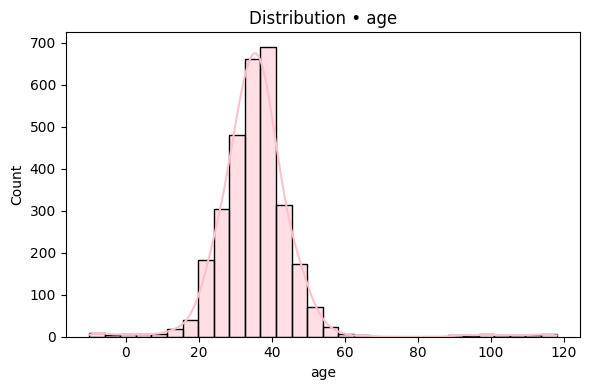

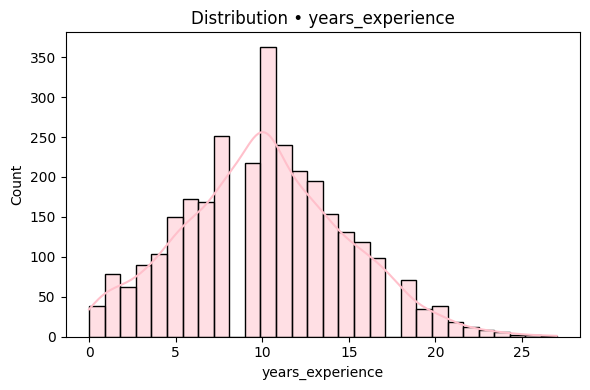

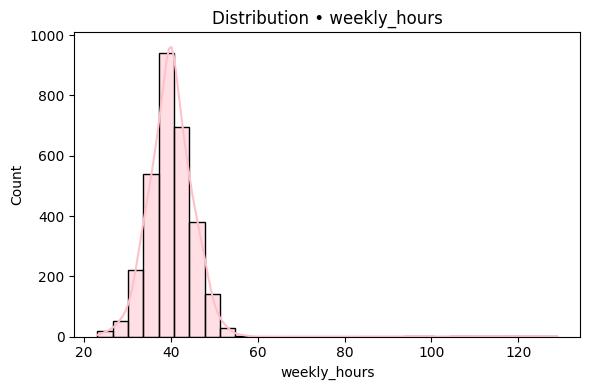

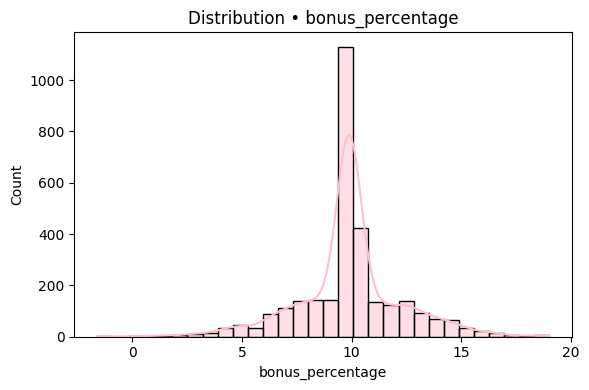

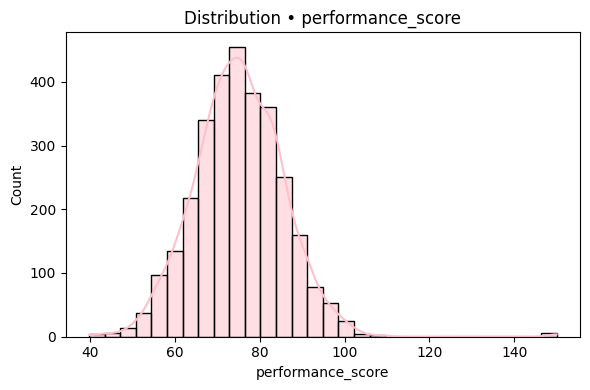

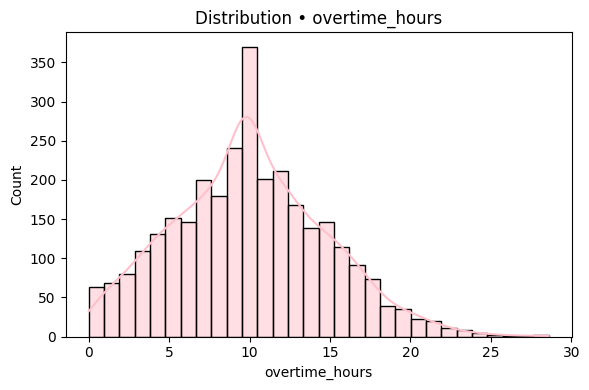

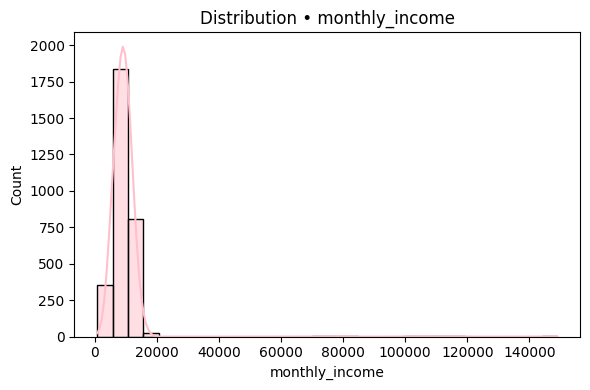

In [69]:
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df1[col].dropna(), bins=30, kde=True, color="pink")
    plt.title(f"Distribution • {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


And now for numeric boxplots with outliers

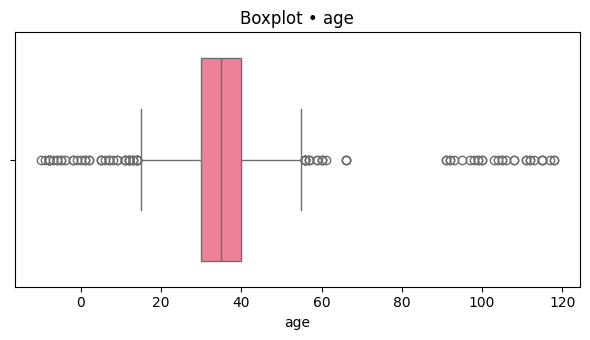

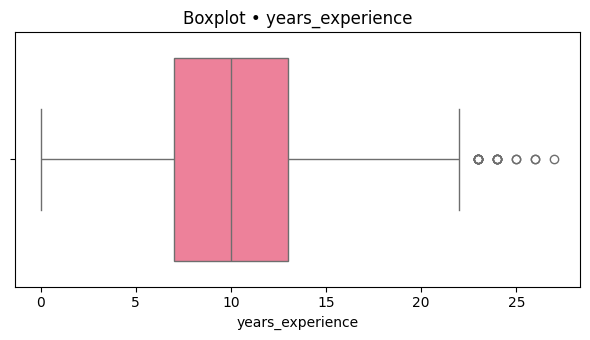

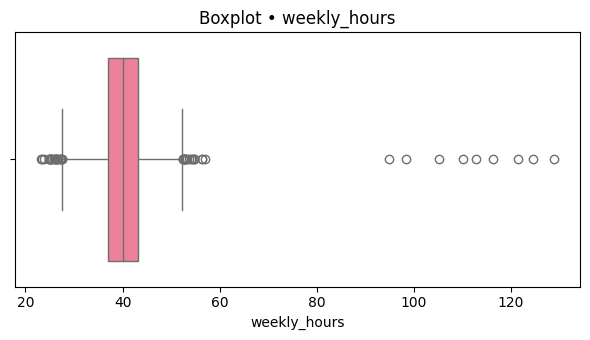

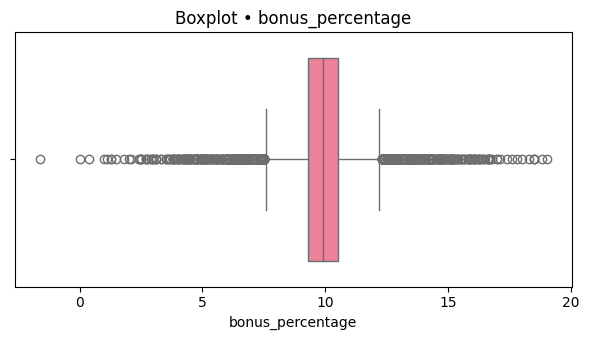

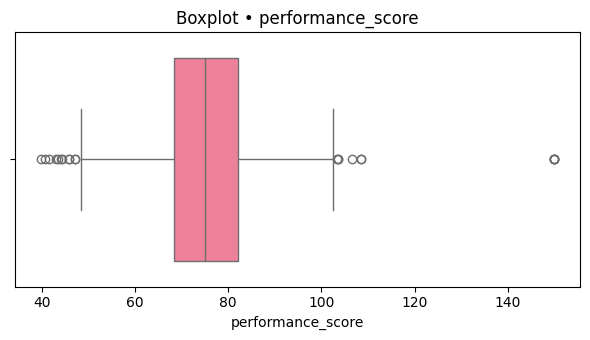

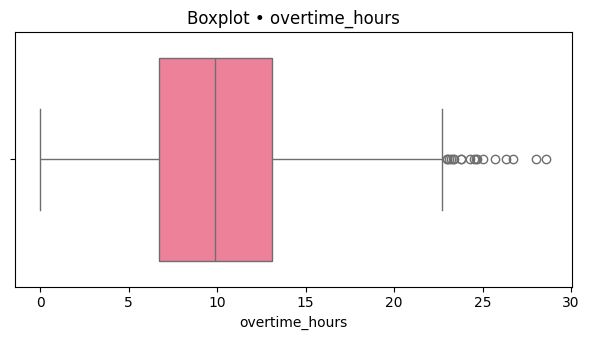

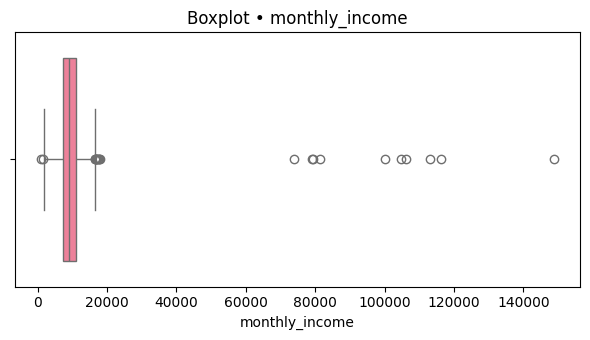

<Axes: xlabel='monthly_income'>

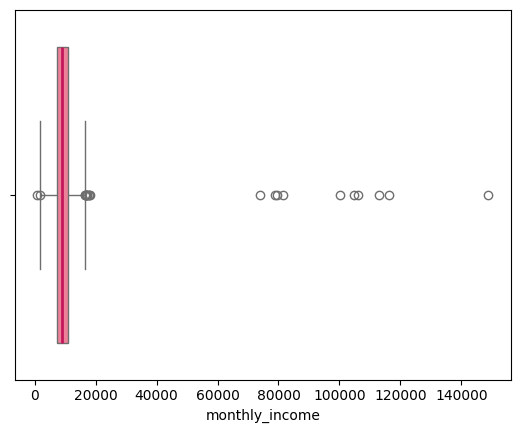

In [70]:
for col in num_cols:
    plt.figure(figsize=(6,3.5))
    sns.boxplot(x=df1[col].dropna(), color="#FF6F91")  # rose pink (differs from "pink")
    plt.title(f"Boxplot • {col}")
    plt.tight_layout()
    plt.show()

sns.boxplot(
    x=df1[col].dropna(),
    color="#FF6F91",
    medianprops=dict(color="#C2185B", linewidth=2)
)

And now for the **categorical counts**

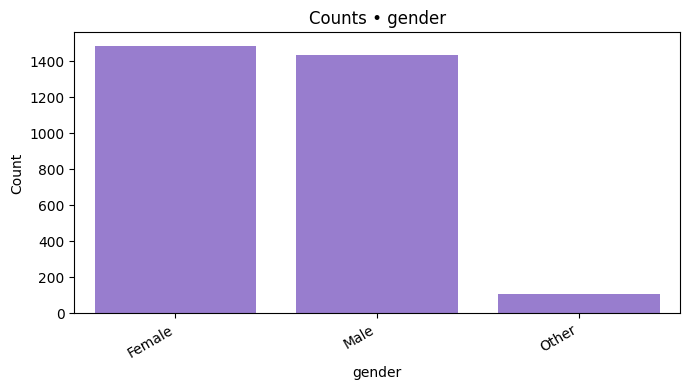

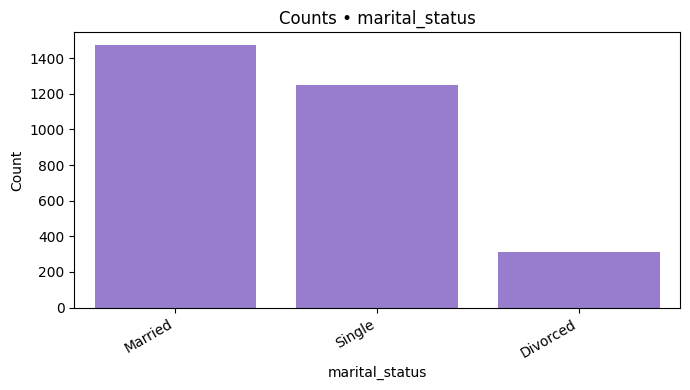

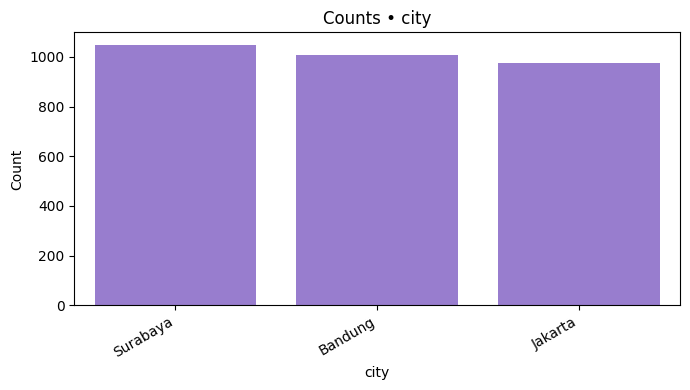

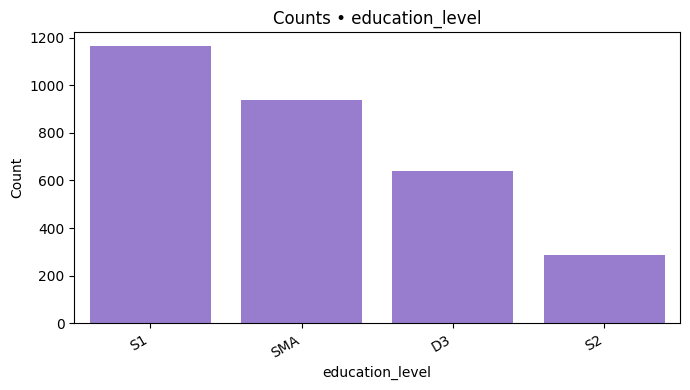

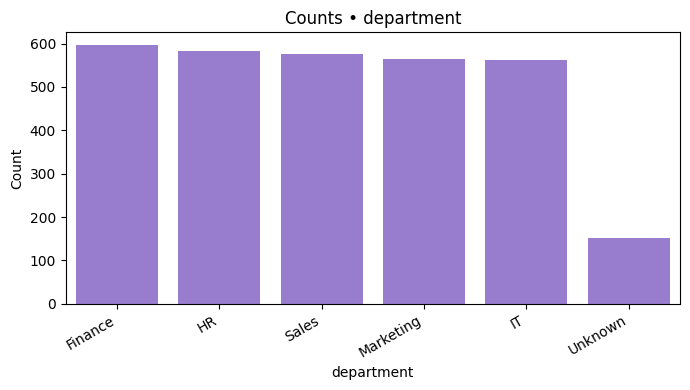

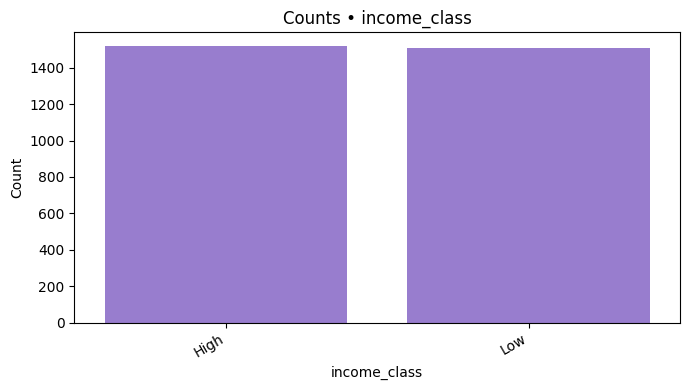

In [71]:
for col in cat_cols:
    plt.figure(figsize=(7,4))
    order = df1[col].value_counts(dropna=False).index
    sns.countplot(
        x=col,
        data=df1,
        order=order,
        color="#9370DB"
    )
    plt.title(f"Counts • {col}")
    plt.xticks(rotation=30, ha="right")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


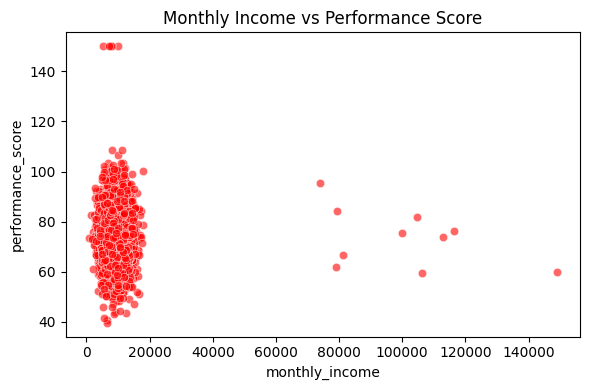

In [72]:
# monthly income vs performance

if "performance_score" in df1.columns:
    # income vs performance
    if "monthly_income" in df1.columns:
        plt.figure(figsize=(6,4))
        sns.scatterplot(
            x="monthly_income",
            y="performance_score",
            data=df1,
            alpha=0.6,
            color="red"
        )
        plt.title("Monthly Income vs Performance Score")
        plt.tight_layout()
        plt.show()


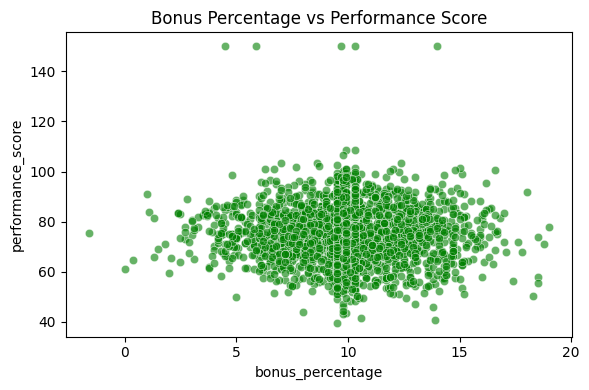

In [73]:
# Bonus vs Performance
if "bonus_percentage" in df1.columns and "performance_score" in df1.columns:
    plt.figure(figsize=(6,4))
    sns.scatterplot(
        x="bonus_percentage",
        y="performance_score",
        data=df1,
        alpha=0.6,
        color="green"
    )
    plt.title("Bonus Percentage vs Performance Score")
    plt.tight_layout()
    plt.show()

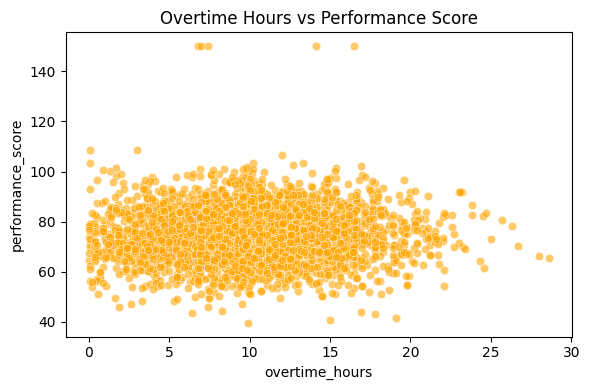

In [74]:
if "overtime_hours" in df1.columns:
    plt.figure(figsize=(6,4))
    sns.scatterplot(
        x="overtime_hours",
        y="performance_score",
        data=df1,
        alpha=0.6,
        color="orange"
    )
    plt.title("Overtime Hours vs Performance Score")
    plt.tight_layout()
    plt.show()

Now, correlation heatmap (numeric only)

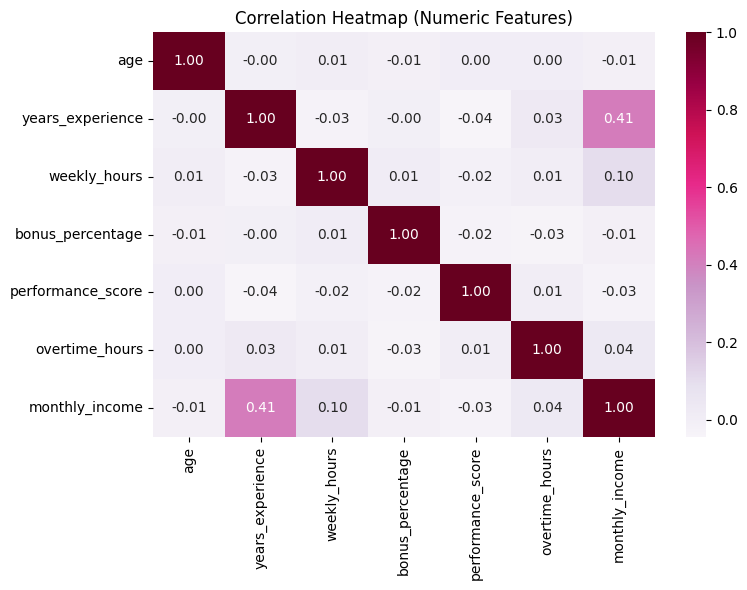

In [75]:
if len(num_cols) >= 2:
    corr = df1[num_cols].corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(
        corr,
        annot=True,
        cmap="PuRd",
        fmt=".2f",
        square=False
    )
    plt.title("Correlation Heatmap (Numeric Features)")
    plt.tight_layout()
    plt.show()
else:
    corr = pd.DataFrame()

Now we are going to save EDA Artifacts

In [76]:
eda_summary = {
    "rows": int(df1.shape[0]),
    "cols": int(df1.shape[1]),
    "id_col": id_col if id_col in df1.columns else None,
    "numeric_cols": num_cols,
    "categorical_cols": cat_cols,
    "na_counts": {c: int(df1[c].isna().sum()) for c in (num_cols + cat_cols) if c in df1.columns},
    "unique_counts": {c: int(df1[c].nunique(dropna=True)) for c in (num_cols + cat_cols) if c in df1.columns},
    "notes": "EDA results for distributions, outliers, category counts, relationships, and correlations."
}
with open(ARTIFACTS / "eda_summary.json", "w") as f:
    json.dump(eda_summary, f, indent=2)

In [77]:
# save correlation matrix (joblib for the quick load later)
joblib.dump(corr, ARTIFACTS / "corr_matrix.joblib")

['artifacts/corr_matrix.joblib']

In [78]:
# save column lists (handy for validation in later phases)
joblib.dump(
    {"numeric_cols": num_cols, "categorical_cols": cat_cols, "id_col": eda_summary["id_col"]},
    ARTIFACTS / "column_lists.joblib"
)

['artifacts/column_lists.joblib']

In [79]:
print("✅ EDA complete.")
print(f"Saved: {ARTIFACTS/'eda_summary.json'}")
print(f"Saved: {ARTIFACTS/'corr_matrix.joblib'}")
print(f"Saved: {ARTIFACTS/'column_lists.joblib'}")

✅ EDA complete.
Saved: artifacts/eda_summary.json
Saved: artifacts/corr_matrix.joblib
Saved: artifacts/column_lists.joblib


Now we want to exclude the `employeee_id`

In [80]:
# Enforce id_col exists — fail fast if missing
id_col = "employee_id"
if id_col not in df1.columns:
    raise ValueError(f"id_col '{id_col}' not found in df1. Add/rename it before proceeding.")

In [81]:
# Ensure column lists match df1 exactly
num_cols = [c for c in num_cols if c in df1.columns]
cat_cols = [c for c in cat_cols if c in df1.columns]

In [82]:
# Rebuild & overwrite EDA summary with strict id_col + schema version
eda_summary.update({
    "id_col": id_col,
    "numeric_cols": num_cols,
    "categorical_cols": cat_cols,
    "schema_version": "v0.1"
})
with open(ARTIFACTS / "eda_summary.json", "w") as f:
    json.dump(eda_summary, f, indent=2)

In [83]:
# correlation guard (compute if missing)
try:
    _ = corr.shape
except NameError:
    import pandas as pd
    corr = df1[num_cols].corr() if len(num_cols) >= 2 else pd.DataFrame()
joblib.dump(corr, ARTIFACTS / "corr_matrix.joblib")

['artifacts/corr_matrix.joblib']

# **PHASE 2 - Feature Engineering**

In [84]:
from datetime import datetime


## **Define columns**
Firstly, we configure schema & enforce required columns.

In [85]:
# artifacts folder
ARTIFACTS = Path("artifacts")
ARTIFACTS.mkdir(parents=True, exist_ok=True)

In [86]:
# ID column (must exist — fail fast if not found)
ID_COL = "employee_id"
if ID_COL not in df1.columns:
    raise ValueError(f"Required id column '{ID_COL}' not found in df1.")

In [87]:
COL_PERF         = "performance_score"
COL_BONUS        = "bonus_percentage"
COL_OT           = "overtime_hours"
COL_INCOME       = "monthly_income"
COL_INCOME_CLASS = "income_class"
COL_MARITAL      = "marital_status"

In [88]:
REQ_RISK_COLS = [COL_PERF, COL_BONUS, COL_OT, COL_INCOME, COL_INCOME_CLASS, COL_MARITAL]
missing = [c for c in REQ_RISK_COLS if c not in df1.columns]
if missing:
    raise ValueError(f"Missing required risk features: {missing}")

In [89]:
# make sure risk numerics are already in numeric
for c in [COL_PERF, COL_BONUS, COL_OT, COL_INCOME]:
    df1[c] = pd.to_numeric(df1[c], errors="coerce")

In [90]:
# tidy categoricals (stable casing)
df1[COL_INCOME_CLASS] = df1[COL_INCOME_CLASS].astype(str).str.strip().str.title()
df1[COL_MARITAL]      = df1[COL_MARITAL].astype(str).str.strip().str.title()

print("✅ Schema validated. Risk features ready.")

✅ Schema validated. Risk features ready.


After make sure the schema is validated we are moving to compute thresholds & category levels.

And also,
## **Define Threshold**

In [91]:
# quantile thresholds
HIGH_PERF_Q  = 0.70  # high performance = top 30%
LOW_BONUS_Q  = 0.30  # low bonus = bottom 30%
HIGH_OT_Q    = 0.70  # high overtime = top 30%
LOW_INCOME_Q = 0.30  # low income = bottom 30%

In [92]:
# Convert to numeric cut values from your current df1
perf_hi_val   = float(df1[COL_PERF].quantile(HIGH_PERF_Q))
bonus_lo_val  = float(df1[COL_BONUS].quantile(LOW_BONUS_Q))
ot_hi_val     = float(df1[COL_OT].quantile(HIGH_OT_Q))
income_lo_val = float(df1[COL_INCOME].quantile(LOW_INCOME_Q))

In [93]:
# risk bucket cutoffs for the 0–100 rule-based score (used later)
RISK_HIGH_CUT = 60.0
RISK_LOW_CUT  = 30.0

In [94]:
# values treated as 'single-like' (mobility proxy)
MARITAL_SINGLE_VALUES = ["Single", "S"]

In [95]:
# capture category levels (for validation & UI filters)
income_class_levels = df1[COL_INCOME_CLASS].value_counts(dropna=False).index.astype(str).tolist()
marital_levels      = df1[COL_MARITAL].value_counts(dropna=False).index.astype(str).tolist()

### Then, we build and save to .`json`

In [96]:
model_meta = {
    "version": "v0.1",
    "created_at": datetime.utcnow().strftime("%Y-%m-%dT%H:%M:%SZ"),
    "id_col": ID_COL,  # assumes ID_COL is defined

    # Reference to the 6 risk features
    "risk_features": {
        "performance_score": COL_PERF,
        "bonus_percentage": COL_BONUS,
        "overtime_hours": COL_OT,
        "monthly_income": COL_INCOME,
        "income_class": COL_INCOME_CLASS,
        "marital_status": COL_MARITAL
    }
}

/tmp/ipython-input-4068389483.py:3: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "created_at": datetime.utcnow().strftime("%Y-%m-%dT%H:%M:%SZ"),


In [97]:
# for init & core metadata
from datetime import datetime
import json

model_meta = {
    "version": "v0.1",
    "created_at": datetime.utcnow().strftime("%Y-%m-%dT%H:%M:%SZ"),
    "id_col": ID_COL,  # assumes ID_COL is defined

    # reference to the 6 risk features
    "risk_features": {
        "performance_score": COL_PERF,
        "bonus_percentage": COL_BONUS,
        "overtime_hours": COL_OT,
        "monthly_income": COL_INCOME,
        "income_class": COL_INCOME_CLASS,
        "marital_status": COL_MARITAL
    }
}

/tmp/ipython-input-2543008556.py:7: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "created_at": datetime.utcnow().strftime("%Y-%m-%dT%H:%M:%SZ"),


In [98]:
# for thresholds, categories, notes
model_meta["thresholds"] = {
    "quantiles": {
        "high_perf_q": HIGH_PERF_Q,
        "low_bonus_q": LOW_BONUS_Q,
        "high_ot_q": HIGH_OT_Q,
        "low_income_q": LOW_INCOME_Q
    },
    "values": {
        "perf_hi_val":   perf_hi_val,
        "bonus_lo_val":  bonus_lo_val,
        "ot_hi_val":     ot_hi_val,
        "income_lo_val": income_lo_val
    },
    "risk_bucket_cuts": {
        "high_cut": RISK_HIGH_CUT,
        "low_cut":  RISK_LOW_CUT
    },
    "marital_single_values": MARITAL_SINGLE_VALUES
}

model_meta["categories"] = {
    "income_class_levels": income_class_levels,
    "marital_status_levels": marital_levels
}

model_meta["notes"] = {
    "risk_index": "Rule-based snapshot risk (0–100). Not time-bound.",
    "performance_split": "High performance if performance_score >= perf_hi_val.",
    "provenance": "Thresholds derived from df1 at save time."
}


In [99]:
# for save to JSON
with open(ARTIFACTS / "model_meta.json", "w") as f:
    json.dump(model_meta, f, indent=2)

print(f"Saved model_meta.json → {ARTIFACTS/'model_meta.json'}")


Saved model_meta.json → artifacts/model_meta.json


In [100]:
# quick preview to read
from pprint import pprint
print("model_meta.json preview (key parts):")
pprint({
    "id_col": model_meta["id_col"],
    "thresholds.values": model_meta["thresholds"]["values"],
    "risk_bucket_cuts": model_meta["thresholds"]["risk_bucket_cuts"],
    "income_class_levels": model_meta["categories"]["income_class_levels"][:5],
    "marital_status_levels": model_meta["categories"]["marital_status_levels"][:5],
})


model_meta.json preview (key parts):
{'id_col': 'employee_id',
 'income_class_levels': ['High', 'Low'],
 'marital_status_levels': ['Married', 'Single', 'Divorced'],
 'risk_bucket_cuts': {'high_cut': 60.0, 'low_cut': 30.0},
 'thresholds.values': {'bonus_lo_val': 9.5,
                       'income_lo_val': 7698.4,
                       'ot_hi_val': 12.2,
                       'perf_hi_val': 80.5}}


# **PHASE 3 - Preprocessing Pipeline**

### Define columns

Lets check if `employee_id` still exsist as "None" or not.

In [101]:
ID_COL = "employee_id"
assert ID_COL in df1.columns, f"{ID_COL} not found in df1."

In [102]:
NUM_COLS = [
    "age",
    "years_experience",
    "weekly_hours",
    "bonus_percentage",
    "performance_score",
    "overtime_hours",
    "monthly_income",
]

In [103]:
CAT_COLS = [
    "gender",
    "marital_status",
    "city",
    "education_level",
    "department",
    "income_class",
]

In [104]:
# keep only those that exist (defensive)
NUM_COLS = [c for c in NUM_COLS if c in df1.columns]
CAT_COLS = [c for c in CAT_COLS if c in df1.columns]

In [105]:
print("NUM_COLS:", NUM_COLS)
print("CAT_COLS:", CAT_COLS)
print("Rows:", len(df1))


NUM_COLS: ['age', 'years_experience', 'weekly_hours', 'bonus_percentage', 'performance_score', 'overtime_hours', 'monthly_income']
CAT_COLS: ['gender', 'marital_status', 'city', 'education_level', 'department', 'income_class']
Rows: 3030


### Build the pipeline

OHE

In [106]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=True, with_std=True), NUM_COLS),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), CAT_COLS),
    ],
    remainder="drop",
)

In [107]:
prep_pipeline = Pipeline(steps=[("preprocess", preprocess)])
print("Preprocessing pipeline created.")

Preprocessing pipeline created.


### Fit once (lock categoris & save artifacts)

In [108]:
ARTIFACTS = Path("artifacts")
ARTIFACTS.mkdir(parents=True, exist_ok=True)

In [109]:
# fit on current clean data to lock encoder vocabularies
_ = prep_pipeline.fit(df1[NUM_COLS + CAT_COLS])

In [110]:
# save preprocess-only pipeline as .pkl
with open(ARTIFACTS / "pipeline_prep.pkl", "wb") as f:
    pickle.dump(prep_pipeline, f)

In [111]:
# save schema snapshot as .joblib
schema_snapshot = {
    "id_col": ID_COL,
    "numeric_cols": NUM_COLS,
    "categorical_cols": CAT_COLS,
    "n_rows_fitted": int(len(df1)),
}
joblib.dump(schema_snapshot, ARTIFACTS / "clean_cols.joblib")

['artifacts/clean_cols.joblib']

In [112]:
print(" SAVED:", ARTIFACTS / "pipeline_prep.pkl")
print(" SAVED:", ARTIFACTS / "clean_cols.joblib")

 SAVED: artifacts/pipeline_prep.pkl
 SAVED: artifacts/clean_cols.joblib


In [113]:
# quick check for transformed shape
try:
    X_sample = prep_pipeline.transform(df1[NUM_COLS + CAT_COLS])[:5]
    print("Transformed sample shape:", X_sample.shape)
except Exception as e:
    print("Note: transform preview skipped:", e)

Transformed sample shape: (5, 28)


# **PHASE 4 - Clustering (Layer A)**

### Load preprocess & define features

In [114]:
ARTIFACTS = Path("artifacts")
with open(ARTIFACTS / "pipeline_prep.pkl", "rb") as f:
    prep_pipeline = pickle.load(f)

In [115]:
ID_COL = "employee_id"
assert ID_COL in df1.columns, f"{ID_COL} not in df1."

In [116]:
# numeric  features
NUM_COLS = [
    "age","years_experience","weekly_hours","bonus_percentage",
    "performance_score","overtime_hours","monthly_income",
]

In [117]:
# categorical features
CAT_COLS = [
    "gender","marital_status","city","education_level","department","income_class"
]

In [118]:
# keep only those present
NUM_COLS = [c for c in NUM_COLS if c in df1.columns]
CAT_COLS = [c for c in CAT_COLS if c in df1.columns]

In [119]:
print("Using features:", NUM_COLS + CAT_COLS)

Using features: ['age', 'years_experience', 'weekly_hours', 'bonus_percentage', 'performance_score', 'overtime_hours', 'monthly_income', 'gender', 'marital_status', 'city', 'education_level', 'department', 'income_class']


### Transform data & compute Elbow (SSE)

In [120]:
X = prep_pipeline.transform(df1[NUM_COLS + CAT_COLS])

In [121]:
K_CANDIDATES = list(range(2, 11))  # 2..10 for elbow curve
sse = []
for k in K_CANDIDATES:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X)
    sse.append(km.inertia_)

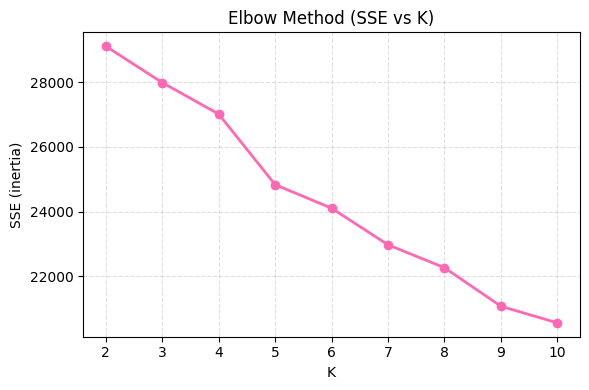

In [122]:
plt.figure(figsize=(6,4))
plt.plot(
    K_CANDIDATES, sse,
    marker="o",
    color="#FF69B4",
    markerfacecolor="#FF69B4",
    markeredgecolor="#FF69B4",
    linewidth=2
)
plt.title("Elbow Method (SSE vs K)")
plt.xlabel("K"); plt.ylabel("SSE (inertia)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [123]:
print("Feature matrix shape:", X.shape)

Feature matrix shape: (3030, 28)


### Score K by Silhouette & Davies-Boulding

In [124]:
K_EVAL = [3,4,5,6,7,8]
records = []

In [125]:
for k in K_EVAL:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X)
    try:
        sil = silhouette_score(X, labels)
    except Exception:
        sil = np.nan
    try:
        dbi = davies_bouldin_score(X, labels)
    except Exception:
        dbi = np.nan
    records.append({"K": k, "silhouette": sil, "davies_bouldin": dbi})

In [126]:
eval_df = pd.DataFrame(records).sort_values(["silhouette","davies_bouldin"], ascending=[False, True])
eval_df.reset_index(drop=True)

,K,silhouette,davies_bouldin
0,3,0.120354,2.124235
1,8,0.071762,2.264972
2,5,0.070941,2.603587
3,7,0.069583,2.232120
4,4,0.066382,3.160386
5,6,0.065945,2.571549


**Interpretations:**

* **Silhouette score (higher is better, max =1)**
  * Best at **K = 3 (0.120) → relatively weak but the highest among candidates.
  * Drops sharply after K=3, meaning clusters beyond that are less well-separated

* **Davies-Boulding Index (lower is better)**
  * Best at **K=3 (2.12)** → lowest DBI compared to others.
  * Higher for K=4.8, which porrer compactness/separation.
  

**Conclusion:**

Both metrics agree that **K = 3**, is the best choice. The silhouette is low overall, but that's common in high-dimensional HR data (after OHE).

### Select final K

In [127]:
best_row = eval_df.sort_values(["silhouette","davies_bouldin"], ascending=[False, True]).iloc[0]
BEST_K = int(best_row["K"])
BEST_SIL = float(best_row["silhouette"])
BEST_DBI = float(best_row["davies_bouldin"])

In [128]:
print(f"Selected K = {BEST_K}")
print(f"Silhouette = {BEST_SIL:.3f} | Davies–Bouldin = {BEST_DBI:.3f}")

Selected K = 3
Silhouette = 0.120 | Davies–Bouldin = 2.124


### Fit final KMeans, save full pipeline & cluster labels

In [129]:
final_pipeline = Pipeline([
    ("preprocess", prep_pipeline.named_steps["preprocess"]),
    ("kmeans", KMeans(n_clusters=BEST_K, n_init=10, random_state=42))
])

In [130]:
final_pipeline.fit(df1[NUM_COLS + CAT_COLS])

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'years_experience',
                                                   'weekly_hours',
                                                   'bonus_percentage',
                                                   'performance_score',
                                                   'overtime_hours',
                                                   'monthly_income']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['gender', 'marital_status',
                                                   'city', 'education_level',
                                                   'department',
                                                   'income_class'])])),
                ('kmeans', KMeans(n_clusters=3, n_init=10, random_state=42))])

In [131]:
# predict clusters
cluster_labels = final_pipeline.predict(df1[NUM_COLS + CAT_COLS]).astype(int)

In [132]:
# save full pipeline
with open(ARTIFACTS / "pipeline_tuned.pkl", "wb") as f:
    pickle.dump(final_pipeline, f)

In [133]:
# save cluster labels (aligned with employee_id)
labels_df = pd.DataFrame({ID_COL: df1[ID_COL].values, "cluster": cluster_labels})
joblib.dump(labels_df, ARTIFACTS / "cluster_labels.joblib")

['artifacts/cluster_labels.joblib']

In [134]:
print("✅ Saved pipeline_tuned.pkl & cluster_labels.joblib")
labels_df.head()

✅ Saved pipeline_tuned.pkl & cluster_labels.joblib


,employee_id,cluster
0,1,0
1,2,1
2,3,0
3,4,0
4,5,1


### Update m`odel_meta.json` with chosen K

In [135]:
meta_path = ARTIFACTS / "model_meta.json"
with open(meta_path, "r") as f:
    model_meta = json.load(f)

In [136]:
model_meta.setdefault("clustering", {})
model_meta["clustering"].update({
    "features_used": NUM_COLS + CAT_COLS,
    "best_k": BEST_K,
    "metrics": {"silhouette": BEST_SIL, "davies_bouldin": BEST_DBI}
})

In [137]:
with open(meta_path, "w") as f:
    json.dump(model_meta, f, indent=2)

In [138]:
print(f"Updated {meta_path}")

Updated artifacts/model_meta.json


### Cluster profiling

In [139]:
prof = df1.merge(labels_df, on=ID_COL, how="left")

In [140]:
# summary of key numeric metrics
summary = prof.groupby("cluster").agg({
    "performance_score": ["mean","median","count"],
    "monthly_income": ["mean","median"],
    "bonus_percentage": ["mean","median"],
    "overtime_hours": ["mean","median"]
}).round(2)

In [141]:
# top departments by cluster
top_dept = (prof.groupby(["cluster","department"])
                 .size().reset_index(name="count")
                 .sort_values(["cluster","count"], ascending=[True,False])
                 .groupby("cluster").head(3))

In [142]:
print("Cluster summaries (numeric features):")
display(summary)

Cluster summaries (numeric features):


performance_score              monthly_income           \
                     mean median count           mean   median   
cluster                                                          
0                   75.63  75.40  1527        6968.17   7242.0   
1                   74.40  74.30  1529       11695.46  10941.0   
2                   73.33  72.55    34       15683.56   9847.0   

        bonus_percentage        overtime_hours         
                    mean median           mean median  
cluster                                                
0                   9.91    9.9           9.88   9.85  
1                   9.88    9.9          10.11   9.85  
2                   9.80    9.9          10.35  10.52

In [143]:
print("\nTop departments per cluster:")
display(top_dept)


Top departments per cluster:


,cluster,department,count
3,0,Marketing,306
1,0,HR,305
0,0,Finance,287
6,1,Finance,318
10,1,Sales,311
8,1,IT,284
15,2,Marketing,12
12,2,Finance,7
13,2,HR,7


### Light Cluster Profiling Visualizations

In [144]:
prof = df1.merge(labels_df, on=ID_COL, how="left")

/tmp/ipython-input-2381418909.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="cluster", y="performance_score", data=prof, ax=axes[0,0], ci=None, color=pink)
/tmp/ipython-input-2381418909.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="cluster", y="monthly_income", data=prof, ax=axes[0,1], ci=None, color=purple)
/tmp/ipython-input-2381418909.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="cluster", y="bonus_percentage", data=prof, ax=axes[1,0], ci=None, color=light_blue)
/tmp/ipython-input-2381418909.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="cluster", y="overtime_hours", data=prof, ax=axes[1,1], ci=None, color=orange)


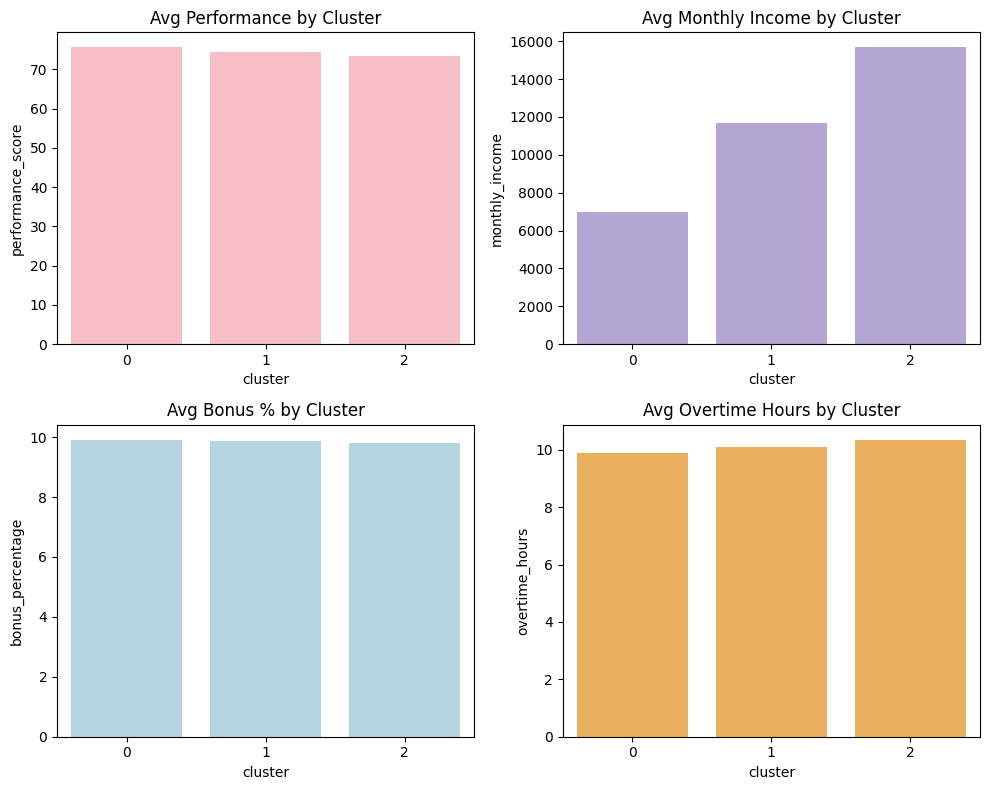

In [145]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

pink       = "#FFB6C1"
purple     = "#B39DDB"
light_blue = "#ADD8E6"
orange     = "#FFB347"

sns.barplot(x="cluster", y="performance_score", data=prof, ax=axes[0,0], ci=None, color=pink)
axes[0,0].set_title("Avg Performance by Cluster")

sns.barplot(x="cluster", y="monthly_income", data=prof, ax=axes[0,1], ci=None, color=purple)
axes[0,1].set_title("Avg Monthly Income by Cluster")

sns.barplot(x="cluster", y="bonus_percentage", data=prof, ax=axes[1,0], ci=None, color=light_blue)
axes[1,0].set_title("Avg Bonus % by Cluster")

sns.barplot(x="cluster", y="overtime_hours", data=prof, ax=axes[1,1], ci=None, color=orange)
axes[1,1].set_title("Avg Overtime Hours by Cluster")

plt.tight_layout()
plt.show()


**Interpretations:**

* **Performance:** All clusters are very close (74-75). Cluster 0 is marginally highest; differences look small → performance is essentially **flat across clusters.**
* **Monthly income:** clear gradient **C0<C1<C2** (roughly 7k → 11.5k → 16k). **income is the main driver** sparating clusters.
* **Bonus %**: almost idential across clusters (9.8-10%). Bonuses appear **policy-driven**, not strongly tied to cluster or performance.
* **Overtime hours:** all near 10 hours; slight increase with cluster index (C2 a touch higher). **minimal separation** here.


**What this means**
* Your clustering is **primarily segmenting pay bands**; behavior/performance variables contribute little separation.
* **Misalignment risk**: pay differences aren't mirrored by performance or bonus-could raise fariness/perception issues.
* **Operational note**: slight overtime creep in the highest-paid cluster; watch for workload/burnout.

And now, what we are going to do is;

### visualization as radar chart (spider plot) for cluster comparison

In [146]:
metrics = ["performance_score", "monthly_income", "bonus_percentage", "overtime_hours"]

then we normalize each metric (min-max) for fair radar comparison

In [147]:
radar_data = prof.groupby("cluster")[metrics].mean()
radar_norm = (radar_data - radar_data.min()) / (radar_data.max() - radar_data.min())

In [148]:
labels = metrics
num_vars = len(labels)

/tmp/ipython-input-3829300431.py:16: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(top=0.90)


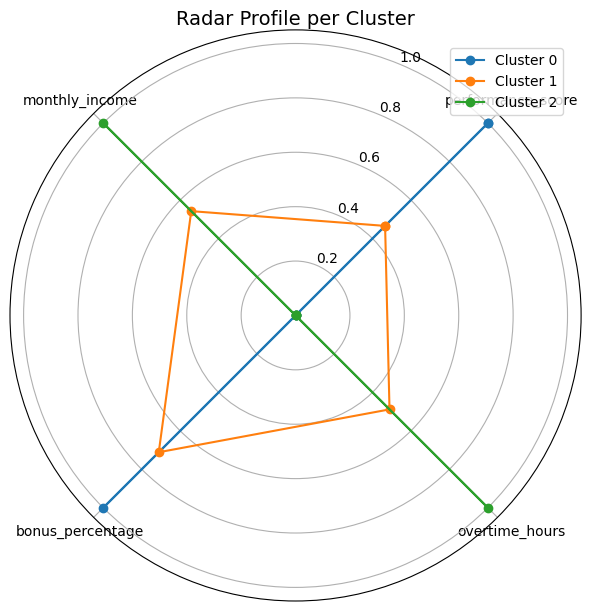

In [149]:
angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True), constrained_layout=True)

ax.set_theta_offset(np.pi / num_vars)

for idx, row in radar_norm.iterrows():
    values = row.tolist() + [row.tolist()[0]]
    ax.plot(angles, values, marker="o", label=f"Cluster {idx}")

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

ax.set_title("Radar Profile per Cluster", fontsize=14, pad=4)
fig.subplots_adjust(top=0.90)
ax.legend(loc="upper right", bbox_to_anchor=(0.98, 0.98), bbox_transform=ax.transAxes)

plt.show()

### **Interpretations**

**Cluster 0 (Blue line)**
* Very high performance scores and bonus percentage.
* Very low monthly income and overtime hours.
* **means:** these employees maybe highly efficient, working fewer overtime hours but rewarded with bonuses for results. Their fixed salary iss low, so bonuses are their main incentive.

**Cluster 1 (orange line)**
* Balanced and moderate across all four dimensions.
* Neither extreme high or nor low in performance, income, bonus, or overtime.
* **means:** this cluster represents average employees: steady performers with decent pay and manageable workloads.

**Cluster 2 (Green line)**
* Very **high monthly income** and **overtime hours**, but **low performance scores** and **bonus percentage.**
* means: these employees may be in higher-paying positions but are overworked and not producing strong results. Their bonuses are minimal, likely because performance is not meeting expectations.

**Overall:**
* **Cluster 0**L High performers, thrive on bonuses rather than base salary, efficient with minimal overtime.
* **Cluster 1** balanced group, average in all aspects, forming the "middle ground."
* **Cluster 2** high earners with heavy overtime but low effectiveness; possibly at risk of burnout or disenggaments

Then we are going to save numeric cluster profile.

In [150]:
prof = df1.merge(labels_df, on="employee_id", how="left")

In [151]:
profile_numeric = (
    prof.groupby("cluster")[["performance_score","monthly_income","bonus_percentage","overtime_hours"]]
        .agg(["mean","median","count"])
        .round(2)
)

In [152]:
ARTIFACTS = Path("artifacts")
joblib.dump(profile_numeric, ARTIFACTS / "cluster_profile_numeric.joblib")

['artifacts/cluster_profile_numeric.joblib']

In [153]:
print("Saved:", ARTIFACTS / "cluster_profile_numeric.joblib")
profile_numeric

Saved: artifacts/cluster_profile_numeric.joblib


performance_score              monthly_income                 \
                     mean median count           mean   median count   
cluster                                                                
0                   75.63  75.40  1527        6968.17   7242.0  1527   
1                   74.40  74.30  1529       11695.46  10941.0  1529   
2                   73.33  72.55    34       15683.56   9847.0    34   

        bonus_percentage              overtime_hours               
                    mean median count           mean median count  
cluster                                                            
0                   9.91    9.9  1527           9.88   9.85  1527  
1                   9.88    9.9  1529          10.11   9.85  1529  
2                   9.80    9.9    34          10.35  10.52    34

# **PHASE 5 - Risk Index (Layer B)**

First thing first, load thresholds & config from `model_meta.json`

In [154]:
ARTIFACTS = Path("artifacts")
meta_path = ARTIFACTS / "model_meta.json"

In [155]:
with open(meta_path, "r") as f:
    model_meta = json.load(f)

In [156]:
with open(meta_path, "r") as f:
    model_meta = json.load(f)

In [157]:
COL_PERF         = model_meta["risk_features"]["performance_score"]
COL_BONUS        = model_meta["risk_features"]["bonus_percentage"]
COL_OT           = model_meta["risk_features"]["overtime_hours"]
COL_INCOME       = model_meta["risk_features"]["monthly_income"]
COL_INCOME_CLASS = model_meta["risk_features"]["income_class"]
COL_MARITAL      = model_meta["risk_features"]["marital_status"]

In [158]:
cuts = model_meta["thresholds"]["values"]
RISK_HIGH_CUT = model_meta["thresholds"]["risk_bucket_cuts"]["high_cut"]
RISK_LOW_CUT  = model_meta["thresholds"]["risk_bucket_cuts"]["low_cut"]
MARITAL_SINGLE_VALUES = model_meta["thresholds"]["marital_single_values"]

In [159]:
print("Loaded thresholds:")
cuts

Loaded thresholds:


{'perf_hi_val': 80.5,
 'bonus_lo_val': 9.5,
 'ot_hi_val': 12.2,
 'income_lo_val': 7698.4}

### Define the scoring function (transparent rules)

In [160]:
# weights
W_HIGH_PERF_LOW_BONUS = 30
W_HIGH_OT             = 20
W_LOW_INCOME          = 25
W_LOW_INCOME_CLASS    = 5
W_SINGLE              = 10

In [161]:
# lowest income class label (prefer 'Low' if present, else best guess)
income_class_levels = model_meta.get("categories", {}).get("income_class_levels", [])
ordered_map = {"Low": 0, "Mid": 1, "Middle": 1, "Medium": 1, "High": 2}
if "Low" in [str(x) for x in income_class_levels]:
    LOWEST_INCOME_CLASS = "Low"
elif income_class_levels:
    LOWEST_INCOME_CLASS = sorted(income_class_levels, key=lambda x: ordered_map.get(str(x), 99))[0]
else:
    LOWEST_INCOME_CLASS = "Low"

Then we do scoring function

In [162]:
def compute_risk_scores(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute 0–100 risk_score, bucket (High/Medium/Low), and drivers per employee.
    Uses global variables loaded from model_meta (cuts, thresholds, column names).
    """
    score = pd.Series(0.0, index=df.index, dtype="float64")
    drivers = [[] for _ in range(len(df))]

    # normalize once
    lowest_inc_cls = str(LOWEST_INCOME_CLASS).strip().title()
    single_set = {str(v).strip().title() for v in MARITAL_SINGLE_VALUES}

    for i, row in df[[COL_PERF, COL_BONUS, COL_OT, COL_INCOME, COL_INCOME_CLASS, COL_MARITAL]].iterrows():
        s = 0.0

        # 1. high performance + low bonus
        if pd.notna(row[COL_PERF]) and pd.notna(row[COL_BONUS]):
            if row[COL_PERF] >= cuts["perf_hi_val"] and row[COL_BONUS] <= cuts["bonus_lo_val"]:
                s += W_HIGH_PERF_LOW_BONUS
                drivers[i].append("High performance + low bonus")

        # 2. high overtime
        if pd.notna(row[COL_OT]) and row[COL_OT] >= cuts["ot_hi_val"]:
            s += W_HIGH_OT
            drivers[i].append("High overtime")

        # 3. low income vs peers
        if pd.notna(row[COL_INCOME]) and row[COL_INCOME] <= cuts["income_lo_val"]:
            s += W_LOW_INCOME
            drivers[i].append("Low income vs peers")

        # 4. lowest income class
        if pd.notna(row[COL_INCOME_CLASS]):
            if str(row[COL_INCOME_CLASS]).strip().title() == lowest_inc_cls:
                s += W_LOW_INCOME_CLASS
                drivers[i].append("Low income class")

        # 5. single-like marital status
        if pd.notna(row[COL_MARITAL]):
            if str(row[COL_MARITAL]).strip().title() in single_set:
                s += W_SINGLE
                drivers[i].append("Single (mobility proxy)")

        score.loc[i] = max(0.0, min(100.0, s))

     # Bucketize and assemble
    def bucketize(x: float) -> str:
        if pd.isna(x): return "Unknown"
        if x >= RISK_HIGH_CUT: return "High"
        if x <= RISK_LOW_CUT:  return "Low"
        return "Medium"

    risk_bucket = score.apply(bucketize)
    driver_text = pd.Series([", ".join(d) if d else "—" for d in drivers], index=df.index)

    return pd.DataFrame({
        ID_COL: df[ID_COL].values,
        "risk_score": score.round(1),
        "risk_bucket": risk_bucket,
        "drivers": driver_text
    })



### Compute scores

In [163]:
risk_df = compute_risk_scores(df1)
display(risk_df.head())

,employee_id,risk_score,risk_bucket,drivers
0,1,15.0,Low,"Low income class, Single (mobility proxy)"
1,2,10.0,Low,Single (mobility proxy)
2,3,50.0,Medium,"High overtime, Low income vs peers, Low income..."
3,4,60.0,High,"High overtime, Low income vs peers, Low income..."
4,5,20.0,Low,High overtime


### Save artifacts + persist weights to meta

In [164]:
ARTIFACTS = Path("artifacts")
joblib.dump(risk_df, ARTIFACTS / "risk_lookup.joblib")
print("Saved:", ARTIFACTS / "risk_lookup.joblib")

Saved: artifacts/risk_lookup.joblib


In [165]:
model_meta.setdefault("risk_scoring", {})
model_meta["risk_scoring"]["weights"] = {
    "high_perf_low_bonus": W_HIGH_PERF_LOW_BONUS,
    "high_overtime": W_HIGH_OT,
    "low_income": W_LOW_INCOME,
    "low_income_class": W_LOW_INCOME_CLASS,
    "single_status": W_SINGLE
}
with open(ARTIFACTS / "model_meta.json", "w") as f:
    json.dump(model_meta, f, indent=2)
print(" Updated model_meta.json with risk weights.")

 Updated model_meta.json with risk weights.


### Distribution summary (sanity check)

In [166]:
summary_risk = (
    risk_df["risk_bucket"].value_counts(dropna=False)
    .rename_axis("risk_bucket")
    .reset_index(name="count")
)

In [167]:
summary_risk["percent"] = (summary_risk["count"] / len(risk_df) * 100).round(1)
summary_risk

,risk_bucket,count,percent
0,Low,2231,73.6
1,Medium,580,19.1
2,High,219,7.2


**summary**
* **Total records:** 3030.
* **Low risk** become the majority (73.6%)
* **medium risk** to resign is in 19.1%
* **High risk** to resign is at lowest (7.2%)


# **PHASE 6 - Performance x Risk Quadrant**

### Build performance flag from saved cutoff

In [168]:
ARTIFACTS = Path("artifacts")
with open(ARTIFACTS / "model_meta.json", "r") as f:
    model_meta = json.load(f)

In [169]:
ID_COL   = model_meta["id_col"]
COL_PERF = model_meta["risk_features"]["performance_score"]
perf_hi_val = model_meta["thresholds"]["values"]["perf_hi_val"]

In [170]:
# flag: high / low performance
perf_flag = (df1[COL_PERF] >= perf_hi_val).map({True: "High", False: "Low"})
perf_df = df1[[ID_COL, COL_PERF]].copy()
perf_df["performance_band"] = perf_flag

In [171]:
display(perf_df.head())
print("High performance cutoff:", perf_hi_val)

,employee_id,performance_score,performance_band
0,1,64.3,Low
1,2,87.6,High
2,3,61.5,Low
3,4,81.6,High
4,5,71.9,Low


High performance cutoff: 80.5


### Join with `risk_df` and assign quadrants

In [172]:
assert "risk_df" in globals(), "Run Phase 5 first to create risk_df."


In [173]:
quad_df = (
    perf_df[[ID_COL, "performance_band"]]
    .merge(risk_df[[ID_COL, "risk_bucket", "risk_score", "drivers"]], on=ID_COL, how="left")
)

In [174]:
def quadrant(row):
    if row["performance_band"] == "High" and row["risk_bucket"] == "High":
        return "High Perf / High Risk"
    if row["performance_band"] == "High" and row["risk_bucket"] in ("Medium", "Low"):
        return "High Perf / Low Risk"
    if row["performance_band"] == "Low" and row["risk_bucket"] == "High":
        return "Low Perf / High Risk"
    return "Low Perf / Low Risk"

In [175]:
quad_df["quadrant"] = quad_df.apply(quadrant, axis=1)

In [176]:
display(quad_df.head())

,employee_id,performance_band,risk_bucket,risk_score,drivers,quadrant
0,1,Low,Low,15.0,"Low income class, Single (mobility proxy)",Low Perf / Low Risk
1,2,High,Low,10.0,Single (mobility proxy),High Perf / Low Risk
2,3,Low,Medium,50.0,"High overtime, Low income vs peers, Low income...",Low Perf / Low Risk
3,4,High,High,60.0,"High overtime, Low income vs peers, Low income...",High Perf / High Risk
4,5,Low,Low,20.0,High overtime,Low Perf / Low Risk


### Summarize (counts & percentages)

In [177]:
total = len(quad_df)

In [178]:
summary = (
    quad_df["quadrant"]
    .value_counts()
    .rename_axis("quadrant")
    .reset_index(name="count")
    .sort_values("quadrant")
)

In [179]:
summary["percent"] = (summary["count"] / total * 100).round(1)

then we make the matrix (2x2, performance x risk)

In [180]:
matrix = (
    quad_df
    .pivot_table(index="performance_band", columns="risk_bucket", values=ID_COL, aggfunc="count", fill_value=0)
    .reindex(index=["High","Low"], columns=["High","Medium","Low"])
)

In [181]:
display(summary)
print("\nPerformance × Risk (counts):")
display(matrix)

,quadrant,count,percent
2,High Perf / High Risk,151,4.9
1,High Perf / Low Risk,774,25.0
3,Low Perf / High Risk,72,2.3
0,Low Perf / Low Risk,2093,67.7



Performance × Risk (counts):


risk_bucket,High,Medium,Low
performance_band,,,
High,151,228,546
Low,72,362,1731


### Add cluster info for drilldowns

In [182]:
if "labels_df" in globals():
    quad_df = quad_df.merge(labels_df, on=ID_COL, how="left")
    qxcl = (
        quad_df.groupby(["quadrant","cluster"])
        .size().reset_index(name="count")
        .sort_values(["quadrant","count"], ascending=[True, False])
    )
    print("Quadrant × Cluster (top view):")
    display(qxcl.head(12))
else:
    print("Note: labels_df not found (skip quadrant × cluster cross-tab).")


Quadrant × Cluster (top view):


,quadrant,cluster,count
0,High Perf / High Risk,0,133
1,High Perf / High Risk,1,21
2,High Perf / High Risk,2,1
4,High Perf / Low Risk,1,437
3,High Perf / Low Risk,0,348
5,High Perf / Low Risk,2,9
6,Low Perf / High Risk,0,75
7,Low Perf / High Risk,2,1
9,Low Perf / Low Risk,1,1143
8,Low Perf / Low Risk,0,1015


### Save artifacts

In [183]:
ARTIFACTS = Path("artifacts")
joblib.dump(quad_df, ARTIFACTS / "quadrant_assignments.joblib")
joblib.dump(summary, ARTIFACTS / "quadrant_summary.joblib")
print("Saved:", ARTIFACTS / "quadrant_assignments.joblib")
print("Saved:", ARTIFACTS / "quadrant_summary.joblib")
summary

Saved: artifacts/quadrant_assignments.joblib
Saved: artifacts/quadrant_summary.joblib


,quadrant,count,percent
2,High Perf / High Risk,151,4.9
1,High Perf / Low Risk,774,25.0
3,Low Perf / High Risk,72,2.3
0,Low Perf / Low Risk,2093,67.7


# **PHASE 7 - Quick Sanity Check**

### Check `risk_lookup.joblib`

In [191]:
ARTIFACTS = Path("artifacts")

In [192]:
risk_df_check = joblib.load(ARTIFACTS / "risk_lookup.joblib")
print("risk_lookup.joblib loaded:", risk_df_check.shape)
display(risk_df_check.head())

risk_lookup.joblib loaded: (3030, 4)


,employee_id,risk_score,risk_bucket,drivers
0,1,15.0,Low,"Low income class, Single (mobility proxy)"
1,2,10.0,Low,Single (mobility proxy)
2,3,50.0,Medium,"High overtime, Low income vs peers, Low income..."
3,4,60.0,High,"High overtime, Low income vs peers, Low income..."
4,5,20.0,Low,High overtime


### Check `quadrant_summary.joblib`

In [193]:
quad_summary_check = joblib.load(ARTIFACTS / "quadrant_summary.joblib")
print("quadrant_summary.joblib loaded:", quad_summary_check.shape)
display(quad_summary_check)

quadrant_summary.joblib loaded: (4, 3)


,quadrant,count,percent
2,High Perf / High Risk,151,4.9
1,High Perf / Low Risk,774,25.0
3,Low Perf / High Risk,72,2.3
0,Low Perf / Low Risk,2093,67.7


### Check `model_meta.json`

In [194]:
with open(ARTIFACTS / "model_meta.json", "r") as f:
    meta_check = json.load(f)

print("model_meta.json keys:", list(meta_check.keys()))
print("Clustering info:", meta_check.get("clustering", {}))
print("Risk scoring weights:", meta_check.get("risk_scoring", {}))


model_meta.json keys: ['version', 'created_at', 'id_col', 'risk_features', 'thresholds', 'categories', 'notes', 'clustering', 'risk_scoring']
Clustering info: {'features_used': ['age', 'years_experience', 'weekly_hours', 'bonus_percentage', 'performance_score', 'overtime_hours', 'monthly_income', 'gender', 'marital_status', 'city', 'education_level', 'department', 'income_class'], 'best_k': 3, 'metrics': {'silhouette': 0.12035367780050209, 'davies_bouldin': 2.1242349324552605}}
Risk scoring weights: {'weights': {'high_perf_low_bonus': 30, 'high_overtime': 20, 'low_income': 25, 'low_income_class': 5, 'single_status': 10}}


### Check pipeline_tuned.pkl

In [195]:
# load the full pipeline
with open(ARTIFACTS / "pipeline_tuned.pkl", "rb") as f:
    pipeline_check = pickle.load(f)

In [196]:
# take a small sample of rows
sample = df1.sample(5, random_state=42)

In [197]:
# predict clusters
pred_clusters = pipeline_check.predict(sample[NUM_COLS + CAT_COLS])
print("Pipeline loaded and predicted clusters:", pred_clusters)

Pipeline loaded and predicted clusters: [0 0 0 0 1]


In [ ]:
# transform features
X_trans = pipeline_check.named_steps["preprocess"].transform(sample[NUM_COLS + CAT_COLS])
print("Transformed sample shape:", X_trans.shape)

### Check `pipeline_prep.pkl`

In [198]:
# load preprocess-only pipeline
with open(ARTIFACTS / "pipeline_prep.pkl", "rb") as f:
    prep_check = pickle.load(f)

In [199]:
X_prep = prep_check.transform(sample[NUM_COLS + CAT_COLS])
print("Prep-only pipeline transformed sample shape:", X_prep.shape)

Prep-only pipeline transformed sample shape: (5, 28)


Verify on the disk

In [200]:
print("CWD:", os.getcwd())

art = Path("artifacts")
print("artifacts/ exists:", art.exists(), "| path:", art.resolve())

for p in sorted(art.glob("*")):
    print(f"- {p.name:30s}  {p.stat().st_size/1024:.1f} KB")


CWD: /content
artifacts/ exists: True | path: /content/artifacts
- clean_cols.joblib               0.3 KB
- cluster_labels.joblib           48.2 KB
- cluster_profile_numeric.joblib  2.3 KB
- column_lists.joblib             0.3 KB
- corr_matrix.joblib              1.6 KB
- eda_summary.json                1.1 KB
- model_meta.json                 1.8 KB
- pipeline_prep.pkl               2.6 KB
- pipeline_tuned.pkl              15.5 KB
- quadrant_assignments.joblib     189.6 KB
- quadrant_summary.joblib         1.4 KB
- risk_lookup.joblib              138.6 KB


# **FINAL ANALYSIS**


### **1. Income Distributions**

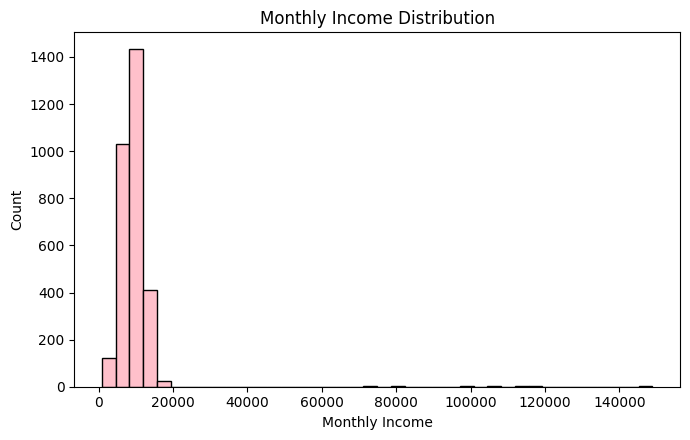

In [215]:
plt.figure(figsize=(7, 4.5))
df['monthly_income'].plot(kind='hist', bins=40, color='pink', edgecolor='black')
plt.title("Monthly Income Distribution")
plt.xlabel("Monthly Income")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



**Interpretations**
* Most employees earn between 8,000-15,000 monthly.
* A small group earns much higher (40k-150k) - they're outliers.

**Summary**
* It shows potential **pay inequality** and the need to check if those top earners are justified through employee clustering.

### 2. **Performance vs Income by Department**

In [203]:
tmp = df.groupby('department', as_index=False).agg(
    avg_income=('monthly_income', 'mean'),
    avg_perf=('performance_score', 'mean'),
    n=('department', 'size')
)

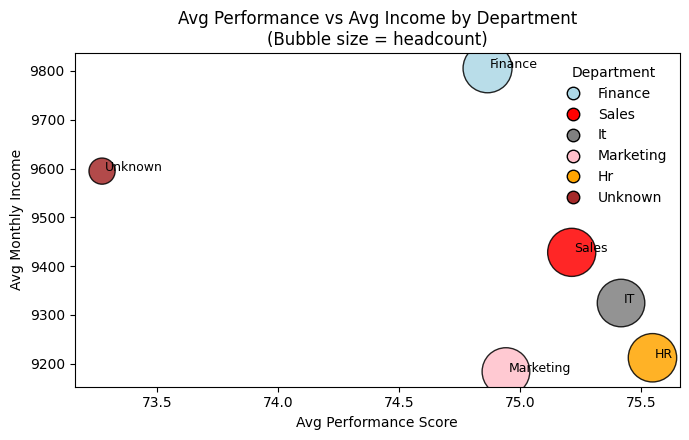

In [216]:
from matplotlib.lines import Line2D

color_map = {
    'finance':  'lightblue',
    'sales':    'red',
    'it':       'grey',
    'marketing':'pink',
    'hr':       'orange',
    'unknown':  'brown'
}

dept_norm = tmp['department'].fillna('unknown').str.lower()
colors = dept_norm.map(color_map).fillna(color_map['unknown'])

plt.figure(figsize=(7, 4.5))
plt.scatter(
    tmp['avg_perf'], tmp['avg_income'],
    s=50 + 2*tmp['n'], c=colors,
    edgecolor='black', alpha=0.85
)

for _, r in tmp.iterrows():
    plt.text(r['avg_perf'] + 0.01, r['avg_income'], r['department'], fontsize=9)

plt.title("Avg Performance vs Avg Income by Department\n(Bubble size = headcount)")
plt.xlabel("Avg Performance Score")
plt.ylabel("Avg Monthly Income")
plt.tight_layout()

present = dept_norm.unique().tolist()
legend_items = []
for key, col in color_map.items():
    if key in present:
        legend_items.append(
            Line2D([0], [0], marker='o', color='w', label=key.title(),
                   markerfacecolor=col, markeredgecolor='black', markersize=9)
        )
plt.legend(handles=legend_items, title="Department", frameon=False)

plt.show()


**Interpretations**
* **Finance**: highest income and good performance.
* **Sales**: relatively high income but not the highest performance.
* **IT & HR**: lower income compared to Finance but with similar performance score.
* **Marketing**: lowest income and slightly lower performance.


### **3. Pay Equity by Gender**

In [205]:
pay_gender = df.groupby('gender')['monthly_income'].median().sort_values(ascending=False)


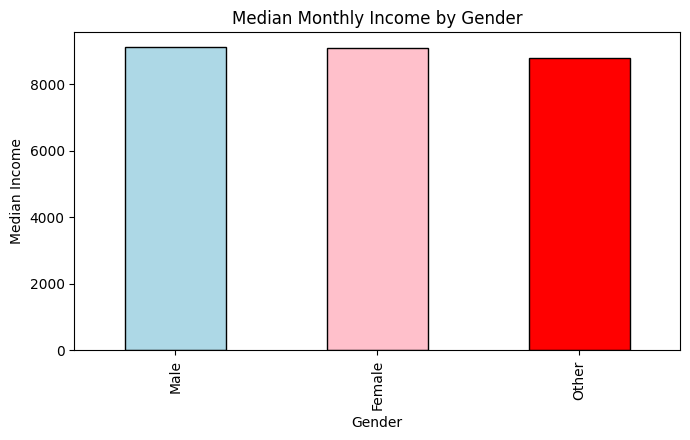

In [217]:
plt.figure(figsize=(7, 4.5))


colors = []
for gender in pay_gender.index:
    g = str(gender).lower()
    if g == "male":
        colors.append("lightblue")
    elif g == "female":
        colors.append("pink")
    else:
        rainbow = plt.cm.rainbow(np.linspace(0, 1, len(pay_gender)))
        colors.append(rainbow[len(colors) % len(rainbow)])

pay_gender.plot(kind='bar', color=colors, edgecolor="black")

plt.title("Median Monthly Income by Gender")
plt.xlabel("Gender")
plt.ylabel("Median Income")
plt.tight_layout()
plt.show()

**Interpretations**
* Both **male** (blue, left) and **female** (pink, middle) have nearly equal median income. Same goes with "Others" too.
* Which means, gender not become the primary issue of the salary earning features.

### **4. Age & Overtime**

**a. Age by Department**

<Figure size 900x450 with 0 Axes>

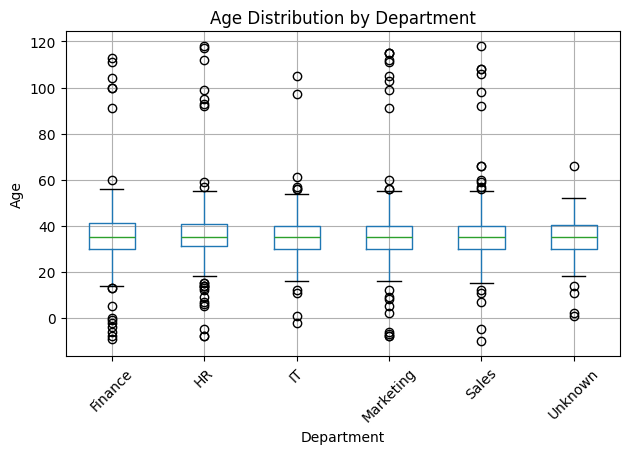

In [212]:
if 'age' in df.columns and 'department' in df.columns:
    plt.figure(figsize=(9, 4.5))
    df.boxplot(column='age', by='department', rot=45)
    plt.title("Age Distribution by Department")
    plt.suptitle("")
    plt.xlabel("Department")
    plt.ylabel("Age")
    plt.tight_layout()
    plt.show()
else:
    print("Skipping 'Age by Department' (need columns: 'age' and 'department').")


**Interpretations**
* All department have similar median age (30s-40s).
* Wide spread in ages


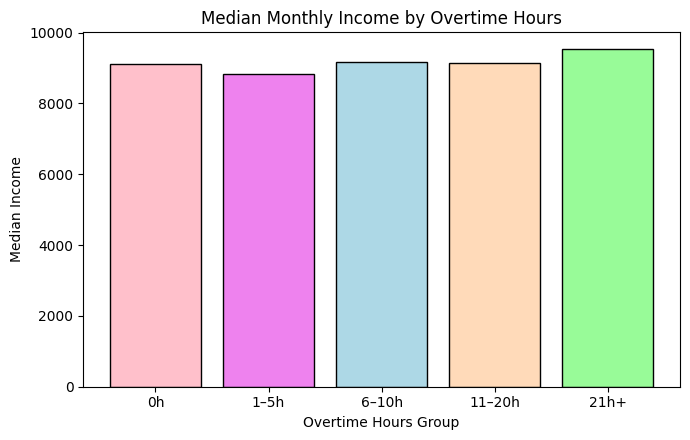

In [218]:
if 'overtime_hours' in df.columns and 'monthly_income' in df.columns:
    plt.figure(figsize=(7, 4.5))

    max_h = float(df['overtime_hours'].max())
    bins = [0, 1, 5, 10, 20, max_h]
    bins = sorted(set(bins))
    if len(bins) < 2 or bins[-1] <= bins[-2]:
        bins = [0, 1, 5, 10, 20, 40]
        max_h = 40.0

    labels = ["0h", "1–5h", "6–10h", "11–20h", "21h+"][:len(bins)-1]


    df['_overtime_group'] = pd.cut(
        df['overtime_hours'].clip(lower=0),
        bins=bins,
        labels=labels,
        include_lowest=True,
        right=True
    )

    med_income = (
        df.groupby('_overtime_group', observed=True)['monthly_income']
          .median()
          .reindex(labels)
    )

    pastel_colors = ["pink", "violet", "lightblue", "peachpuff", "palegreen", "lavender"]
    colors = (pastel_colors * ((len(med_income) // len(pastel_colors)) + 1))[:len(med_income)]

    plt.bar(med_income.index.astype(str), med_income.values, color=colors, edgecolor="black")
    plt.title("Median Monthly Income by Overtime Hours")
    plt.xlabel("Overtime Hours Group")
    plt.ylabel("Median Income")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    df.drop(columns=['_overtime_group'], inplace=True)
else:
    print("Skipping: need 'overtime_hours' and 'monthly_income' columns.")


**Interpreations**
* Employees with **21h+ overtime** earn the highest median income.
* Those with **1-5h overtime** actually earn slightly less than those with no overtime, suggesting uneven recognition.
* Income rises again after 6h+, indicationg **compensation links to heavier overtime only.**.

# **SUMMARY & BUSINESS RECOMMENDATION**

### From the final analysis, we can't solely judgje based on gender, age, or department itself. That's why we need do clustering to know where our employee currently stands for. And here what we got;


### **Cluster 0 - High Performers**
* **Profile**: strong results, driven by bonuses, minimal overtime, lower fixed salary.
* **Risks:** retention risk if base salary feels unfair.
* **Recommendations:**
  * **Financial Security**: Offer retirement plans and health, vision, dental packages to balance their lower fixed pay.
  * **Recognition & Growth**: provide continutie education opportunities to sustain high performance.
  * **Motivation:** Keep performance-based bonuses strong.

### **Cluster 1 - Balanced Group**
* **Profile**: moderate in all aspects; steady workforce.
* **Risks**: risk of stagnation, lack of motivation.
* **Recommendations**
  * Wellness & flexibility: add flexible schedules and more PTO to boost morale.
  * Culture: encourage team bonding activities and food events to increase engagement.
  * **Development**: Provide continuiting education to push them toward high performer status.

### **Cluster 2 - High Earners, Not Effective**
* **Profile:** High salary & overtime, low performance and bonus.
* **Risks:** burnout, poor ROI.
* **Recommendations**
  * **Health & well-beaing:** prioritize mental health support and health & wellness programs to combat burnout.
  * **Work Life Balance**: introduce flexible schedules or pet-friendly policies to improve engagement.
  * **Performance Focus**: pair with **mentorship** (from cluster 0) and review role fit; provide training before escalating.


**Overall Strategy with Benefits**
* **Cluster 0**: retain top talent with financial security + growth opportunities.
* **Cluster 1:** motivate & develop through flexibility, bonding and training.
* **Cluster 2:** reduce burnout and realign contributions with wellness and supportive benefits.